In [1]:
#Imports

import numpy as np
import tensorflow as tf
import time, random
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)

import scipy.stats as ss

/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:
#Parameters

def get_weights(name,shape):
    with tf.variable_scope("weights", reuse=tf.AUTO_REUSE): 
        return tf.get_variable(name=name,shape=shape,initializer = tf.contrib.layers.xavier_initializer(uniform=False),regularizer = tf.contrib.layers.l2_regularizer(tf.constant(0.001, dtype=tf.float32)))
    
def get_bias(name,shape):
    with tf.variable_scope("bias", reuse=tf.AUTO_REUSE):
        return tf.get_variable(name=name,shape=shape,initializer = tf.zeros_initializer())


In [3]:
#Layers

def conv2d(inp,name,kshape,s):
    with tf.variable_scope(name) as scope:
        kernel = get_weights('weights',shape=kshape)
        conv = tf.nn.conv2d(inp,kernel,[1,s,s,1],'SAME')
        bias = get_bias('biases',shape=kshape[3])
        preact = tf.nn.bias_add(conv,bias)
        convlayer = tf.nn.relu(preact,name=scope.name)
    return convlayer

def maxpool(inp,name,k,s):
    return tf.nn.max_pool(inp,ksize=[1,k,k,1],strides=[1,s,s,1],padding='SAME',name=name)


In [4]:
#Losses and Accuracy

def loss(logits,labels):
    labels = tf.reshape(tf.cast(labels,tf.int64),[-1])
    #print labels.get_shape().as_list(),logits.get_shape().as_list()
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,logits=logits,name='cross_entropy_per_example')
    cross_entropy_mean = tf.reduce_mean(cross_entropy,name='cross_entropy')
    total_loss = tf.add(tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)),cross_entropy_mean,name='total_loss')
    return total_loss

def top_1_acc(logits,true_labels):
    pred_labels = tf.argmax(logits,1)
    true_labels = tf.cast(true_labels,tf.int64)
    #print pred_labels.get_shape().as_list(),true_labels
    correct_pred = tf.cast(tf.equal(pred_labels, true_labels), tf.float32)
    accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))
    return accuracy

def top_5_acc(logits,true_labels):
    true_labels = tf.cast(true_labels,tf.int64)
    return tf.reduce_mean(tf.cast(tf.nn.in_top_k(logits, true_labels, k=5,name='top_5_acc'), tf.float32))

In [5]:
#Data Augmentation

def get_new_size():
    new_size = 96 + random.choice([24,16,0])
    return [new_size,new_size]

def get_random_augmentation_combinations(length):
    out = [False,True]
    return [random.choice(out) for i in range(length)]

In [6]:
#Getting Image data

def get_all_images(img_file):
    images = np.fromfile(img_file,dtype=np.uint8).astype(np.float32)
    images = np.reshape(images,(-1,3,96,96))
    images = np.transpose(images,(0,3,2,1))
    print('Normalizing Inputs...')
    rmean = np.mean(images[:,:,:,0])
    gmean = np.mean(images[:,:,:,1])
    bmean = np.mean(images[:,:,:,2])
    images[:,:,:,0] = (images[:,:,:,0] - rmean)#/rstd
    images[:,:,:,1] = (images[:,:,:,1] - gmean)#/gstd
    images[:,:,:,2] = (images[:,:,:,2] - bmean)#/bstd
    print ('R_mean:',rmean,'G_mean:',gmean,'B_mean:',bmean)
    return images,rmean,gmean,bmean

def get_all_labels(label_file):
    labels = np.fromfile(label_file,dtype=np.uint8)
    #print labels.shape
    return labels

def get_test_images(img_file,rmean,gmean,bmean):
    images = np.fromfile(img_file,dtype=np.uint8).astype(np.float32)
    images = np.reshape(images,(-1,3,96,96))
    images = np.transpose(images,(0,3,2,1))
    print('Normalizing Validation Images...')
    images[:,:,:,0] = (images[:,:,:,0] - rmean)#/rstd
    images[:,:,:,1] = (images[:,:,:,1] - gmean)#/gstd
    images[:,:,:,2] = (images[:,:,:,2] - bmean)#/bstd
    return images

In [7]:
#Create dataset
#Getting the dataset


print('Getting the data...')
train_data_path = '/floyd/input/stl10_binary/train_X.bin' #/media/siladittya/fdc481ce-9355-46a9-b381-9001613e3422/siladittya/StudyMaterials/ISI/code/ds/stl10_binary
train_label_path = '/floyd/input/stl10_binary/train_y.bin'

train_img_file = open(train_data_path,'rb')
train_label_file = open(train_label_path,'rb')

train_x,rmean,gmean,bmean = get_all_images(train_img_file)
train_y = get_all_labels(train_label_file)
train_y = train_y - 1
#Getting Validation Dataset
test_img_path = '/floyd/input/stl10_binary/test_X.bin'
test_label_path = '/floyd/input/stl10_binary/test_y.bin'

test_img_file = open(test_img_path,'rb')
test_label_file = open(test_label_path,'rb')

test_x = get_test_images(test_img_file,rmean,gmean,bmean)
test_y = get_all_labels(test_label_file)
test_y = test_y - 1
print('Getting Validation set from Test set...')
val_x = test_x[1:2000]
val_y = test_y[1:2000]

train_x = np.append(train_x,test_x[3000:],axis=0)
train_y = np.append(train_y,test_y[3000:],axis=0)
print("Training Set size = ",train_x.shape)

test_x = test_x[2000:3000]
test_y = test_y[2000:3000]

Getting the data...
Normalizing Inputs...
('R_mean:', 113.91103, 'G_mean:', 112.15152, 'B_mean:', 103.69481)
Normalizing Validation Images...
Getting Validation set from Test set...
('Training Set size = ', (10000, 96, 96, 3))


In [8]:
#Placeholders and constants

index = np.arange(train_x.shape[0])

#........ This part will used to get training data for each epoch during training
num_epochs = 100
batch_size = 50
numiter = 200
ne = 0

feed_images = tf.placeholder(tf.float32,shape=(None,96,96,3))
feed_labels = tf.placeholder(tf.float32,shape=(None,))
lr = tf.placeholder(tf.float32,shape=())
keep_prob = tf.placeholder(tf.float32,shape=())
aug_img = tf.placeholder(tf.float32,shape=(96,96,3))

In [9]:
#VGG 13 ConvNet

with tf.device('/gpu:0'):
    conv1 = conv2d(feed_images,'conv1',[3,3,3,64],1)
    conv2 = conv2d(conv1,'conv2',[3,3,64,64],1)
    pool1 = maxpool(conv2,'pool1',2,2)
    #size = [N,48,48,64]
    conv3 = conv2d(pool1,'conv3',[3,3,64,128],1)
    conv4 = conv2d(conv3,'conv4',[3,3,128,128],1)
    pool2 = maxpool(conv4,'pool2',2,2)
    #size = [N,24,24,128]
    conv5 = conv2d(pool2,'conv5',[3,3,128,256],1)
    conv6 = conv2d(conv5,'conv6',[3,3,256,256],1)
    pool3 = maxpool(conv6,'pool3',2,2)
    #size = [N,12,12,256]
    conv7 = conv2d(pool3,'conv7',[3,3,256,512],1)
    conv8 = conv2d(conv7,'conv8',[3,3,512,512],1)
    pool4 = maxpool(conv8,'pool4',2,2)
    #size = [N,6,6,512]
    conv9 = conv2d(pool4,'conv9',[3,3,512,512],1)
    conv10 = conv2d(conv9,'conv10',[3,3,512,512],1)
    pool5 = maxpool(conv10,'pool5',2,2)
    #size = [N,3,3,512]
    flattened_pool5 = tf.contrib.layers.flatten(pool5)
    fc1 = tf.contrib.layers.fully_connected(flattened_pool5,512,weights_regularizer=tf.contrib.layers.l2_regularizer(tf.constant(0.001, dtype=tf.float32)))
    dropout1 = tf.nn.dropout(fc1,keep_prob)
    fc2 = tf.contrib.layers.fully_connected(dropout1,512,weights_regularizer=tf.contrib.layers.l2_regularizer(tf.constant(0.001, dtype=tf.float32)))
    dropout2 = tf.nn.dropout(fc2,keep_prob)
    logits = tf.contrib.layers.fully_connected(dropout2,10,activation_fn=None,weights_regularizer=tf.contrib.layers.l2_regularizer(tf.constant(0.001, dtype=tf.float32)))

    cost = loss(logits,feed_labels)

    opt_mom = tf.train.AdamOptimizer(learning_rate=0.0001)#,momentum=0.9)
    opt = opt_mom.minimize(cost)

    acc = top_1_acc(logits,feed_labels)
#Defined outside gpu0 device since tf.nn.in_top_k is not supported for gpu kernel
valacc = top_5_acc(logits,feed_labels)

Instructions for updating:
Use the retry module or similar alternatives.


In [10]:
#Data Augmentation

img_scale_crop = tf.random_crop(tf.image.resize_images(aug_img,get_new_size()),[96,96,3])
img_rand_flip_lr = tf.image.random_flip_left_right(aug_img)
img_rand_flip_ud = tf.image.random_flip_up_down(aug_img)
img_con = tf.image.random_contrast(aug_img,0.01,0.25)
img_br = tf.image.random_brightness(aug_img,0.25)
img_rot = tf.contrib.image.rotate(aug_img,0.785*(-0.5+random.random()),interpolation='BILINEAR')

In [12]:
#Training
ne = 0
val_x = val_x[:1000]
val_y = val_y[:1000]
sess = tf.Session()
sess.run(tf.global_variables_initializer())
tl=[]
vl=[]
ta=[]
ta5 = []
va=[]
va5 = []
#builder = tf.saved_model.builder.SavedModelBuilder("/output/vgg13_stl10_model_adam000")

while(ne<30):
    stime = time.time()
    print 'Epoch::',ne+1,'...'
    
    #Shuffling the Dataset
    if ne != 0:
        np.random.shuffle(index)
        train_x = train_x[index]
        train_y = train_y[index]
    
    for niter in range(numiter):
    
        if (niter+1)%50==0:
            print 'iter..',niter+1
        
        #Getting next Batch
        offset = niter*batch_size
        x_iter, y_iter = np.array(train_x[offset:offset+batch_size,:,:,:]), np.array(train_y[offset:offset+batch_size])
        
        #Data Augmentation
        for n in range(batch_size):
            args = get_random_augmentation_combinations(3)
            if args[0]:
                x_iter[n] = sess.run(img_scale_crop,feed_dict={aug_img:x_iter[n]})
            if args[1]:
                x_iter[n] = sess.run(img_rand_flip_lr,feed_dict={aug_img:x_iter[n]})
            if args[2]: 
                x_iter[n] = sess.run(img_rand_flip_ud,feed_dict={aug_img:x_iter[n]})
                
        feed_trdict={feed_images:x_iter,feed_labels:y_iter,keep_prob:0.55}#,lr:0.01
            
        #Train the optimizer
        sess.run(opt,feed_dict=feed_trdict)

    #Calculate accuracy of Training set
    cc = sess.run(cost,feed_dict=feed_trdict)
    tr_acc = sess.run(acc,feed_dict = {feed_images:x_iter,feed_labels:y_iter,keep_prob:1.0})
    top5_tr_acc = sess.run(valacc,feed_dict = {feed_images:x_iter,feed_labels:y_iter,keep_prob:1.0})
    ta.append(tr_acc)
    ta5.append(top5_tr_acc)
    tl.append(cc)
    
    #Calculate accuracy of Validation set
    val_loss = sess.run(cost,feed_dict = {feed_images:val_x,feed_labels:val_y,keep_prob:1.0})
    top5_val_acc = sess.run(valacc,feed_dict = {feed_images:val_x,feed_labels:val_y,keep_prob:1.0})
    top1_val_acc = sess.run(acc,feed_dict = {feed_images:val_x,feed_labels:val_y,keep_prob:1.0})
    va.append(top1_val_acc)
    va5.append(top5_val_acc)
    vl.append(val_loss)
    
    #print 'Epoch..',ne+1,'...'
    print 'Training accuracy-> Top-1::',tr_acc*100,'%','Top-5:: ',top5_tr_acc*100,'%',' Training cost::',cc
    print 'Top-1 Validation accuracy::',top1_val_acc*100,'Top-5 Val Accuracy:: ',top5_val_acc*100,'%',' Val loss: ',val_loss
    print 'Time reqd.::',(time.time()-stime)/60,'mins...'
    #print '{"metric":"Training Accuracy","value":%f}' % (tr_acc*100)
    #print '{"metric":"Training Loss","value":%f}' % cc
    #print '{"metric":"Validation Accuracy","value":%f}' % (val_acc*100)
    #print '{"metric":"Validation Loss","value":%f}' % val_loss

    ne+=1

#builder.add_meta_graph_and_variables(sess, ["EVALUATING"])
#builder.save()

Epoch:: 1 ...
iter.. 50
iter.. 100
iter.. 150
iter.. 200
Training accuracy-> Top-1:: 28.00000011920929 % Top-5::  80.0000011920929 %  Training cost:: 3.5260277
Top-1 Validation accuracy:: 28.9000004529953 Top-5 Val Accuracy::  82.8000009059906 %  Val loss:  3.528161
Time reqd.:: 1.30683900118 mins...
Epoch:: 2 ...
iter.. 50
iter.. 100
iter.. 150
iter.. 200
Training accuracy-> Top-1:: 31.999999284744263 % Top-5::  89.99999761581421 %  Training cost:: 3.2973757
Top-1 Validation accuracy:: 34.00000035762787 Top-5 Val Accuracy::  89.89999890327454 %  Val loss:  3.182498
Time reqd.:: 1.09888631503 mins...
Epoch:: 3 ...
iter.. 50
iter.. 100
iter.. 150
iter.. 200
Training accuracy-> Top-1:: 46.00000083446503 % Top-5::  93.99999976158142 %  Training cost:: 3.0619602
Top-1 Validation accuracy:: 41.29999876022339 Top-5 Val Accuracy::  93.4000015258789 %  Val loss:  2.9291391
Time reqd.:: 1.10035486619 mins...
Epoch:: 4 ...
iter.. 50
iter.. 100
iter.. 150
iter.. 200
Training accuracy-> Top-1:: 54

In [ ]:
builder.add_meta_graph_and_variables(sess, ["EVALUATING"])
builder.save()

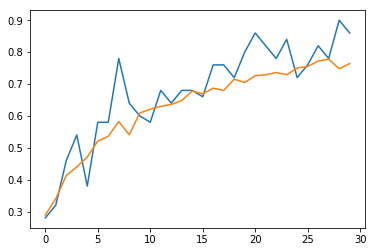

In [13]:
plt.plot(ta)
plt.plot(va)
plt.show()

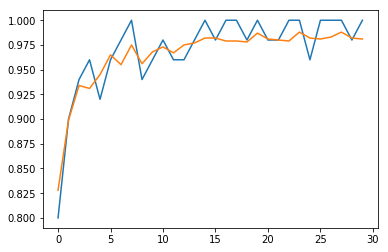

In [14]:
plt.plot(ta5)
plt.plot(va5)
plt.show()

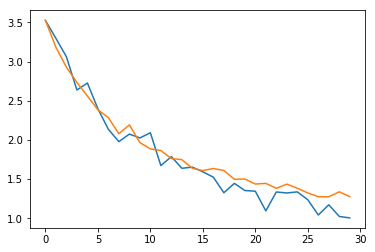

In [15]:
plt.plot(tl)
plt.plot(vl)
plt.show()

In [16]:
top1_test_acc,top5_test_acc = sess.run([acc,valacc],feed_dict={feed_images:test_x,feed_labels:test_y,keep_prob:1.0})
print top1_test_acc*100
print top5_test_acc*100

77.89999842643738
98.4000027179718


In [17]:
unlab_path = '/floyd/input/stl10_binary/unlabeled_X.bin'
unlab_file  = open(unlab_path,'rb')
unlab_x = get_test_images(unlab_file,rmean,gmean,bmean)


Normalizing Validation Images...


In [18]:
!pip install libmr

You are using pip version 8.1.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [19]:
import libmr as mr

In [20]:
#---------------------------------META-RECOGNITION PART 1---------------------------------------#

#penult_layer = tf.random_uniform(shape=[1,10],maxval=1.0)
softmax_layer = tf.nn.softmax(logits)
pred_label = tf.argmax(softmax_layer,1)
_,top5_pred = tf.nn.top_k(softmax_layer, k=5)

mav = {}
av = {}

mav5 = {}
av5 = {}

for i in xrange(10):
    av[i] = np.array([]).reshape((0,10))

with tf.device('/gpu:0'):
    print 'Starting processing activation vectors...'
    stime = time.time()
    stime1=stime
    for i1 in xrange(10000):
        train_img = train_x[i1].reshape((1,96,96,3))
        true_label = train_y[i1]
        if (i1+1)%1000==0:
            print "Analysing","."*int(i1/1000)
            print 'Time for ',i1+1,': ',time.time()-stime,' secs...'
            stime = time.time()
        #For Top-1 classification
        penult,pred_y,top5pred = sess.run([logits,pred_label,top5_pred],feed_dict={feed_images:train_img,keep_prob:1.0})
        pred_y = pred_y[0]
        #stime = time.time()
        #print np.array(penult).shape
        
        if pred_y==true_label:
            av[true_label] = np.append(av[true_label],np.array(penult),axis=0)
            #print av[true_label].shape, pred_y, true_label
        #print'.........................', av
    print 'Completion time:: ', time.time()-stime1,'secs...'
    #Calculating the Mean activation Vector
    print "Calculating the Mean activation Vector..."
    for i in xrange(10):
        mav[i] = np.mean(av[i],axis=0)
        #print mav[i]
    
    dist_from_respmean = {}
    
    for i in xrange(10):
        dist_from_respmean[i] = []
    
    #dist_from_respmean5 = dist_from_respmean
    #Calculating the largest of the Distances
    print "Calculating the largest of the Distances..."
    for i in xrange(10):
        n = av[i].shape[0]
        #print n
        for j in xrange(n):
            penult = av[i][j]
            dist_from_respmean[i].append(np.sqrt(np.sum(np.square(np.subtract(penult,mav[true_label])))))


    #Sorting the distances
    print "Sorting the distances"
    for i in xrange(10):
        dist_from_respmean[i] = sorted(dist_from_respmean[i])
    
    
    #Weibull tail fitting
    models = []
    print "Weibull Tail Fitting..."
    for i in xrange(10):
        meta = mr.MR()
        meta.fit_high(dist_from_respmean[i][-50:],50)
        models.append(meta)


Starting processing activation vectors...
Analysing 
Time for  1000 :  7.43429899216  secs...
Analysing .
Time for  2000 :  7.29038405418  secs...
Analysing ..
Time for  3000 :  7.27782511711  secs...
Analysing ...
Time for  4000 :  7.28787612915  secs...
Analysing ....
Time for  5000 :  7.30083417892  secs...
Analysing .....
Time for  6000 :  7.31784105301  secs...
Analysing ......
Time for  7000 :  7.29618096352  secs...
Analysing .......
Time for  8000 :  7.30067014694  secs...
Analysing ........
Time for  9000 :  7.35049295425  secs...
Analysing .........
Time for  10000 :  7.32626605034  secs...
Completion time::  73.1934330463 secs...
Calculating the Mean activation Vector...
Calculating the largest of the Distances...
Sorting the distances
Weibull Tail Fitting...


Softmax Values:  [0.0000000e+00 3.6129648e-05 1.8145332e-04 2.8006067e-05 1.3884970e-03
 7.1002026e-03 4.2143721e-02 9.4714904e-01 1.8841507e-03 1.4958001e-05
 7.3758631e-05]
Openmax valuess:  [7.40633037e-04 1.37829617e-02 1.15543413e-02 6.66569257e-03
 1.49514905e-02 2.95090648e-02 8.69640497e-02 8.13486700e-01
 2.06350993e-02 4.56510325e-04 1.25345715e-03]


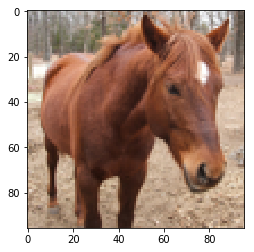

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [7 6 5 8 4]
Revised Top 5: [7 6 5 8 4]
..........................................................................................
Softmax Values:  [0.         0.00064839 0.00842913 0.00064503 0.22000965 0.04947289
 0.6006625  0.09481138 0.02109573 0.00221186 0.00201334]
Openmax valuess:  [0.00624247 0.0611677  0.05690592 0.03166301 0.13104659 0.09300304
 0.35985082 0.16942618 0.07012251 0.01177021 0.00880156]


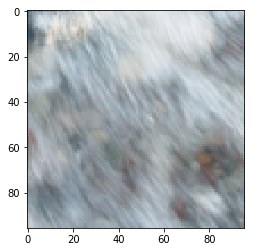

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 4 7 5 8]
Revised Top 5: [6 7 4 5 8]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.6944297e-05 6.0370326e-04 1.7440574e-05 1.9953344e-03
 4.8348708e-03 6.7272383e-01 3.0021727e-01 1.9544385e-02 1.1057048e-05
 2.5213722e-05]
Openmax valuess:  [7.02710898e-04 1.83019482e-02 1.66153151e-02 7.42450153e-03
 1.96014754e-02 2.85737273e-02 3.76756092e-01 4.25140204e-01
 1.06099926e-01 3.44223039e-04 4.39876489e-04]


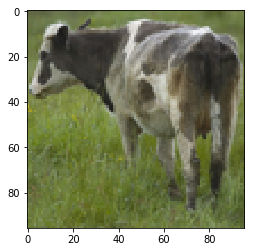

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 7 8 5 4]
Revised Top 5: [7 6 8 5 4]
..........................................................................................
Softmax Values:  [0.0000000e+00 7.1915647e-04 2.5050639e-04 7.2259343e-01 1.2815922e-03
 1.9738436e-05 2.7996046e-04 2.1083184e-04 2.0566210e-04 3.3407803e-03
 2.7109829e-01]
Openmax valuess:  [9.13783361e-03 1.29448300e-02 1.03055581e-02 4.03702760e-02
 1.06586240e-02 2.70777211e-04 1.47972194e-03 1.12852668e-03
 2.26151646e-03 1.65928476e-02 8.94849488e-01]


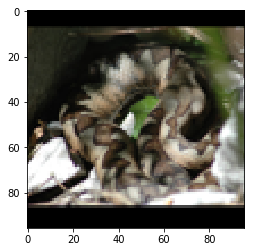

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 3 10  9  4  1]
Revised Top 5: [10  3  9  1  4]
..........................................................................................
Softmax Values:  [0.         0.10212795 0.00200889 0.18712486 0.00151961 0.00087059
 0.00174287 0.00925031 0.00226309 0.0164545  0.67663735]
Openmax valuess:  [0.01068312 0.0273032  0.0222681  0.04497673 0.01362245 0.00480013
 0.00315528 0.01677671 0.00712399 0.02874971 0.82054058]


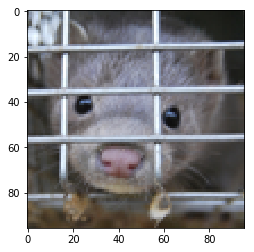

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  1  9  7]
Revised Top 5: [10  3  9  1  2]
..........................................................................................
Softmax Values:  [0.0000000e+00 5.1504653e-03 2.1047691e-02 9.2197627e-01 8.2592592e-03
 4.5178438e-04 1.7316469e-03 6.2050222e-04 3.2947871e-03 5.0228178e-03
 3.2444846e-02]
Openmax valuess:  [0.25048692 0.07892412 0.08432943 0.19188969 0.07271751 0.01392505
 0.0145241  0.00483892 0.03426351 0.04261471 0.21148606]


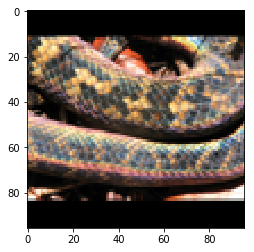

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3 10  2  4  1]
Revised Top 5: [ 0 10  3  2  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 5.5560313e-06 4.0997329e-06 1.6493702e-06 4.4047665e-06
 1.5726894e-04 1.2120249e-03 9.9850881e-01 9.7123528e-05 1.6800236e-07
 8.8510733e-06]
Openmax valuess:  [5.31602880e-05 2.59287252e-03 2.01403099e-03 1.30395817e-03
 1.24161318e-03 4.05953281e-03 1.26061974e-02 9.71513580e-01
 4.05484535e-03 2.66752750e-05 5.33534347e-04]


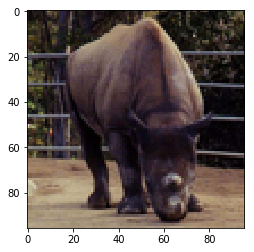

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 7  6  5  8 10]
Revised Top 5: [7 6 5 8 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.2715272e-09 8.1096352e-10 4.2263512e-11 3.8287813e-09
 4.6581430e-03 2.9213477e-05 9.9531263e-01 1.8776074e-08 5.0325757e-11
 9.1728808e-10]
Openmax valuess:  [2.48231824e-04 1.19989599e-07 4.18408826e-08 8.92186388e-08
 1.80699082e-07 6.41161750e-04 1.37367752e-03 9.97735535e-01
 8.87329551e-07 6.95751983e-09 6.77909941e-08]


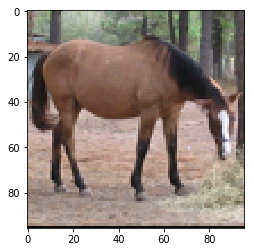

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [7 5 6 8 4]
Revised Top 5: [7 6 5 0 8]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.2239672e-04 1.4699231e-02 4.5889986e-04 3.7546617e-01
 1.0323026e-02 5.5602694e-01 2.8681727e-02 1.2197487e-02 9.3592913e-04
 9.8812545e-04]
Openmax valuess:  [0.00794672 0.05918856 0.06103916 0.03146762 0.17160618 0.05812003
 0.42461198 0.10634651 0.06443417 0.00836301 0.00687607]


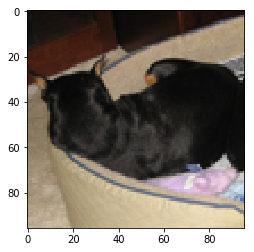

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 4 7 2 8]
Revised Top 5: [6 4 7 8 2]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.8053370e-05 9.9249490e-05 3.1606032e-05 2.2543909e-03
 5.4566069e-03 1.8965043e-01 7.9642868e-01 5.9802164e-03 1.9833780e-05
 6.0997143e-05]
Openmax valuess:  [2.18174879e-04 1.53212002e-02 1.17802285e-02 7.20481743e-03
 1.77732089e-02 2.65958725e-02 1.79974170e-01 6.96802198e-01
 4.28855815e-02 5.16085874e-04 9.28462208e-04]


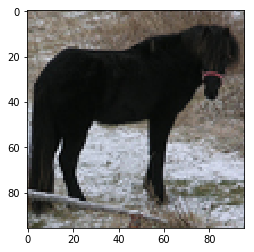

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [7 6 8 5 4]
Revised Top 5: [7 6 8 5 4]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.4175491e-04 1.7581361e-06 2.4068826e-03 7.6821580e-06
 8.7357648e-07 1.6630227e-06 7.9061838e-06 1.2415356e-06 5.0289156e-03
 9.9230134e-01]
Openmax valuess:  [2.42391118e-04 2.55135918e-04 1.70027950e-04 4.80340847e-04
 5.86722696e-05 2.93152687e-06 4.16969670e-06 1.98351233e-05
 3.39764794e-06 5.77961372e-03 9.92983484e-01]


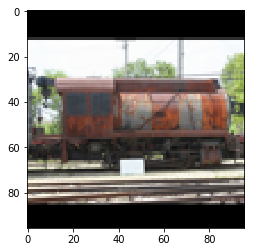

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  9  3  1  7]
Revised Top 5: [10  9  3  1  0]
..........................................................................................
Softmax Values:  [0.0000000e+00 5.6634715e-04 1.6080628e-05 5.9223664e-01 1.5407866e-05
 1.0004128e-06 1.0700501e-05 2.6144498e-05 1.3333766e-05 3.0413509e-04
 4.0681028e-01]
Openmax valuess:  [1.46262888e-02 1.76436324e-03 1.29082144e-03 7.73361931e-03
 3.40694548e-04 6.89243864e-06 5.15787475e-05 1.26149081e-04
 7.87215175e-05 1.52133260e-03 9.72459538e-01]


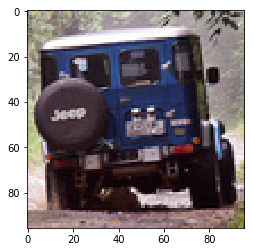

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 3 10  1  9  7]
Revised Top 5: [10  0  3  1  9]
..........................................................................................
Softmax Values:  [0.00000000e+00 8.37383091e-01 6.07101768e-02 1.00475103e-04
 2.20877555e-05 1.33982481e-04 1.51403819e-05 2.33285618e-06
 1.56875285e-05 1.01458825e-01 1.58319453e-04]
Openmax valuess:  [9.62762195e-01 6.60806258e-04 1.02919473e-03 4.45328362e-04
 2.28719385e-04 1.64962819e-04 1.38415126e-05 2.13516017e-06
 1.91822697e-05 3.45051619e-02 1.68473005e-04]


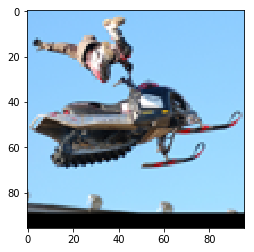

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 1  9  2 10  5]
Revised Top 5: [0 9 2 1 3]
..........................................................................................
Softmax Values:  [0.00000000e+00 2.32649520e-01 8.57240409e-02 1.04192635e-02
 2.51015578e-03 2.12102826e-03 8.78069433e-04 4.49526298e-04
 1.39529502e-03 6.06898189e-01 5.69549836e-02]
Openmax valuess:  [0.26625229 0.02619096 0.03135015 0.02461924 0.01557383 0.00864408
 0.00162808 0.00085572 0.00516254 0.52828412 0.09143898]


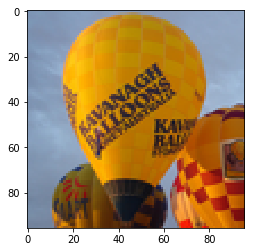

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 9  1  2 10  3]
Revised Top 5: [ 9  0 10  2  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 3.9926828e-08 1.2814100e-03 5.8647595e-07 9.9839991e-01
 2.3194591e-05 2.6953997e-04 5.7500580e-07 1.7786886e-05 4.5901056e-06
 2.3580515e-06]
Openmax valuess:  [1.42461676e-02 3.61529656e-02 5.06813325e-02 1.52638661e-02
 7.34076204e-01 2.80569051e-02 9.31995834e-02 4.89241672e-04
 1.92646389e-02 5.95777856e-03 2.61131624e-03]


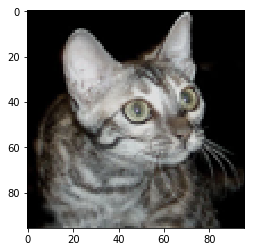

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [4 2 6 5 8]
Revised Top 5: [4 6 2 1 5]
..........................................................................................
Softmax Values:  [0.0000000e+00 3.3083111e-02 9.6308750e-01 4.1738069e-05 3.9632735e-04
 1.2500203e-03 8.6766446e-04 8.7852204e-05 6.3659216e-04 4.7927065e-04
 6.9806068e-05]
Openmax valuess:  [9.44892104e-01 7.71847536e-03 1.49900711e-02 3.90345506e-03
 5.45336437e-03 7.68990073e-03 5.84519980e-03 5.97131473e-04
 4.78160371e-03 3.55828658e-03 5.70408150e-04]


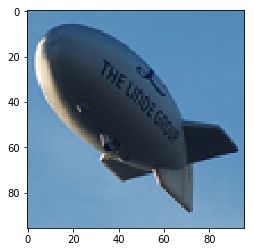

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [2 1 5 6 8]
Revised Top 5: [0 2 1 5 6]
..........................................................................................
Softmax Values:  [0.0000000e+00 5.3737266e-03 4.2527352e-04 9.7607076e-01 1.2170551e-04
 2.4007853e-05 7.0945272e-05 9.0294976e-05 8.9372537e-05 1.4703083e-03
 1.6263589e-02]
Openmax valuess:  [0.3544111  0.04122129 0.0362854  0.15014292 0.01931725 0.00146839
 0.00192081 0.00247321 0.00521065 0.04008635 0.34746263]


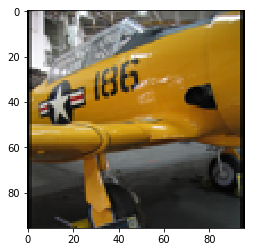

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3 10  1  9  2]
Revised Top 5: [ 0 10  3  1  9]
..........................................................................................
Softmax Values:  [0.         0.04578414 0.11717381 0.29397675 0.02626215 0.00293422
 0.00418938 0.0019084  0.0109506  0.24651207 0.2503085 ]
Openmax valuess:  [0.16034783 0.05739371 0.06378296 0.08520037 0.05029621 0.01458928
 0.00672311 0.00286421 0.02286504 0.24209917 0.29383811]


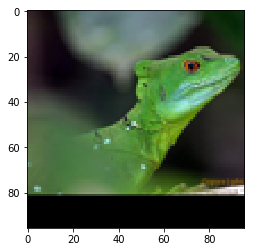

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3 10  9  2  1]
Revised Top 5: [10  9  0  3  2]
..........................................................................................
Softmax Values:  [0.0000000e+00 4.8156963e-08 5.5524782e-12 8.8283505e-06 8.1876922e-11
 8.0838868e-13 1.6788281e-11 1.6934781e-09 4.5074777e-12 3.1652735e-07
 9.9999082e-01]
Openmax valuess:  [6.35905107e-04 7.94692634e-08 3.41354039e-11 2.93121642e-07
 5.03181441e-10 4.98705264e-12 1.03173778e-10 1.04074110e-08
 2.77010806e-11 1.02617000e-06 9.99362685e-01]


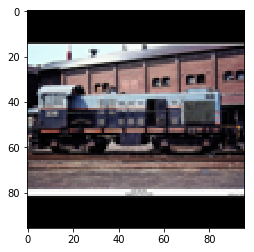

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  9  1  7]
Revised Top 5: [10  0  9  3  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.0506687e-02 1.2123295e-04 1.0438442e-03 1.2221033e-04
 1.1969393e-05 5.9679146e-06 2.1865594e-06 1.1127950e-05 9.8387027e-01
 4.3045664e-03]
Openmax valuess:  [2.79732062e-02 2.11806298e-03 1.84673352e-03 2.47669536e-03
 1.40728196e-03 8.23791713e-05 2.64724661e-05 9.70832093e-06
 6.36516780e-05 9.48670649e-01 1.53251592e-02]


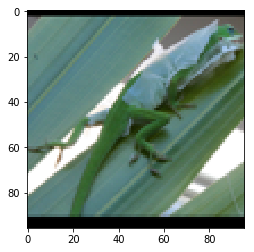

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 9  1 10  3  4]
Revised Top 5: [ 9  0 10  3  1]
..........................................................................................
Softmax Values:  [0.         0.00152074 0.05217065 0.00100435 0.18630536 0.23563421
 0.24086604 0.06427304 0.21533899 0.00122649 0.00166012]
Openmax valuess:  [0.02160431 0.06140128 0.06564594 0.0318515  0.10992807 0.14663046
 0.18429116 0.10392544 0.26447117 0.0052169  0.00503377]


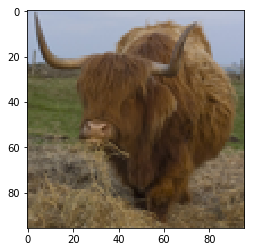

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 5 8 4 7]
Revised Top 5: [8 6 5 4 7]
..........................................................................................
Softmax Values:  [0.0000000e+00 8.0383770e-06 1.6303489e-04 7.9605502e-07 7.9113810e-04
 9.8138303e-01 7.6413560e-03 9.8445052e-03 1.6182184e-04 3.7515329e-06
 2.5177294e-06]
Openmax valuess:  [5.51798663e-03 2.22638189e-02 2.11413803e-02 6.92467703e-03
 3.06190864e-02 5.88244081e-01 1.17682803e-01 1.91139188e-01
 1.54193126e-02 7.20131226e-04 3.27535524e-04]


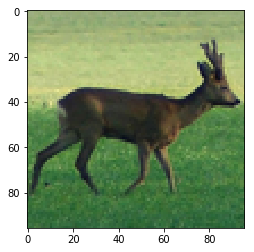

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [5 7 6 4 2]
Revised Top 5: [5 7 6 4 1]
..........................................................................................
Softmax Values:  [0.         0.00169816 0.00665111 0.0010901  0.03047104 0.01455824
 0.50266224 0.2573527  0.18087646 0.00152046 0.00311947]
Openmax valuess:  [0.00354516 0.05008565 0.04522356 0.02844006 0.05820572 0.04554126
 0.26131338 0.24333398 0.24740872 0.006795   0.01010751]


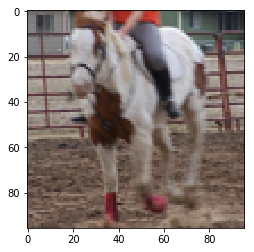

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 7 8 4 5]
Revised Top 5: [6 8 7 4 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 6.1461146e-06 7.1553211e-04 9.9369227e-06 7.8059882e-02
 9.3510066e-04 9.0742445e-01 6.6233794e-03 6.1782678e-03 2.3970388e-05
 2.3407942e-05]
Openmax valuess:  [0.00071062 0.02492296 0.02364375 0.00953582 0.08695405 0.02246771
 0.68198471 0.07004142 0.07794424 0.00108037 0.00071435]


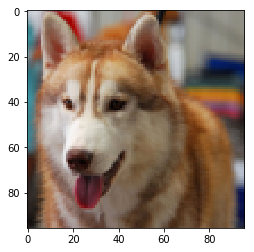

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [6 4 7 8 5]
Revised Top 5: [6 4 8 7 1]
..........................................................................................
Softmax Values:  [0.00000000e+00 1.46867735e-02 5.71910859e-05 4.09958139e-03
 5.44421309e-05 9.19303493e-05 2.04105105e-04 6.30981382e-03
 5.15601496e-05 2.86977482e-03 9.71574843e-01]
Openmax valuess:  [1.19287653e-04 3.09059334e-03 2.21090238e-03 3.71688826e-03
 1.11482580e-03 4.03056901e-04 3.87225605e-04 1.13081329e-02
 2.10826992e-04 4.86047902e-03 9.72577781e-01]


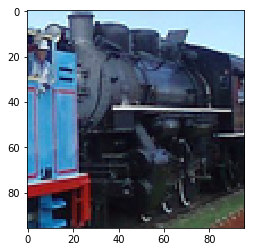

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  1  7  3  9]
Revised Top 5: [10  7  9  3  1]
..........................................................................................
Softmax Values:  [0.         0.02229032 0.21520936 0.02520691 0.53810936 0.05863765
 0.01811636 0.00512645 0.04759438 0.04910207 0.0206071 ]
Openmax valuess:  [0.13511849 0.09665261 0.11080998 0.08273244 0.19173978 0.09926607
 0.05554499 0.01212562 0.08750981 0.08845588 0.04004434]


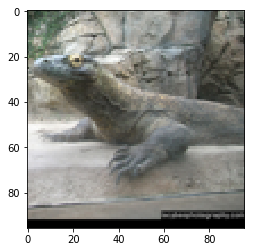

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [4 2 5 9 8]
Revised Top 5: [4 0 2 5 1]
..........................................................................................
Softmax Values:  [0.         0.00407024 0.02542182 0.01361282 0.7339061  0.02531556
 0.06354519 0.01734256 0.03142803 0.04005123 0.04530644]
Openmax valuess:  [0.01250573 0.09335533 0.08890458 0.07472353 0.22111806 0.07665693
 0.11561177 0.04816444 0.07693277 0.09085448 0.10117237]


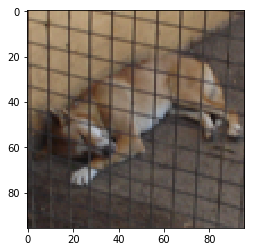

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 4  6 10  9  8]
Revised Top 5: [ 4  6 10  1  9]
..........................................................................................
Softmax Values:  [0.0000000e+00 6.1489809e-02 2.4578886e-03 2.2120764e-02 3.5166816e-04
 1.1613665e-04 7.7560122e-05 3.6887261e-05 1.6666237e-04 8.9950371e-01
 1.3678934e-02]
Openmax valuess:  [1.28303419e-01 9.04176853e-03 8.77786746e-03 1.32242863e-02
 4.61669881e-03 6.07417271e-04 2.12171082e-04 1.01388855e-04
 8.03803772e-04 8.01846197e-01 3.24649818e-02]


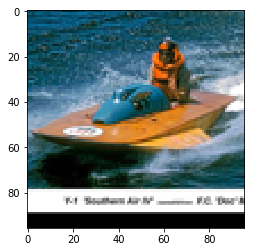

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 9  1  3 10  2]
Revised Top 5: [ 9  0 10  3  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 4.5726099e-03 1.4891704e-03 1.1556131e-03 2.0754742e-03
 2.3047384e-04 2.2013061e-04 6.6481705e-05 6.6187792e-04 9.7723377e-01
 1.2294461e-02]
Openmax valuess:  [3.69128457e-03 8.03830304e-03 7.60745357e-03 6.84365100e-03
 7.52733203e-03 1.86052541e-03 6.92758080e-04 2.12398736e-04
 3.09864873e-03 9.27699046e-01 3.27285987e-02]


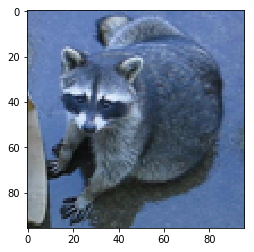

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 9 10  1  4  2]
Revised Top 5: [ 9 10  1  2  4]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.0451673e-05 1.9196048e-03 6.8287023e-05 6.2942527e-02
 1.1837249e-02 2.0220312e-01 1.6917316e-02 7.0394856e-01 4.5027849e-05
 9.7767850e-05]
Openmax valuess:  [4.37273696e-04 1.87184197e-02 1.74094332e-02 8.30855226e-03
 4.29076994e-02 2.89965650e-02 1.33700941e-01 4.54088280e-02
 7.02922920e-01 5.20724847e-04 6.68642607e-04]


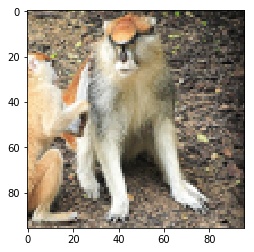

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [8 6 4 7 5]
Revised Top 5: [8 6 7 4 5]
..........................................................................................
Softmax Values:  [0.0000000e+00 3.7385797e-04 4.3434824e-07 1.9569132e-04 8.5650089e-07
 7.9303156e-08 5.2865835e-07 1.0815942e-05 2.0772424e-07 1.5433860e-04
 9.9926323e-01]
Openmax valuess:  [2.34411173e-04 7.13650290e-05 4.76415692e-05 1.07952664e-04
 4.75951228e-06 3.00293286e-07 1.52696324e-06 3.12489179e-05
 6.29409091e-07 3.09029216e-04 9.99191135e-01]


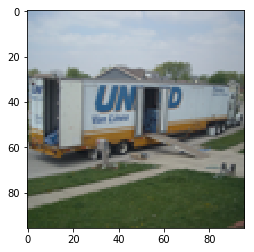

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  1  3  9  7]
Revised Top 5: [10  9  0  3  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 3.3195131e-09 3.7819754e-07 1.1327908e-10 1.2627800e-06
 9.9983919e-01 7.4316235e-06 1.5172629e-04 3.5373624e-08 1.2765713e-09
 7.2736495e-10]
Openmax valuess:  [8.45601649e-05 1.26524678e-03 1.91626455e-03 2.88789629e-04
 3.08629492e-03 6.65548047e-01 3.08562055e-02 2.96745125e-01
 1.86347620e-04 1.73543537e-05 5.76447706e-06]


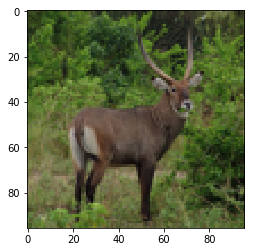

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [5 7 6 4 2]
Revised Top 5: [5 7 6 4 2]
..........................................................................................
Softmax Values:  [0.         0.01013933 0.04550983 0.00985351 0.11226434 0.13466829
 0.4020546  0.08886503 0.1754607  0.00788872 0.01329559]
Openmax valuess:  [0.02649064 0.07957906 0.07822249 0.05661893 0.09909193 0.11465532
 0.21704655 0.10724356 0.18145999 0.017068   0.02252353]


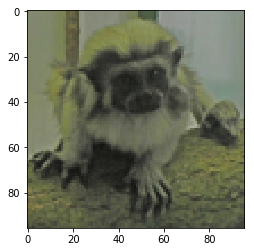

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 8 5 4 7]
Revised Top 5: [6 8 5 7 4]
..........................................................................................
Softmax Values:  [0.         0.04090073 0.01354233 0.66404796 0.00514734 0.00096683
 0.00818494 0.00401654 0.02941008 0.03474326 0.19904001]
Openmax valuess:  [0.0454923  0.07328156 0.06805722 0.13767492 0.04391368 0.01139393
 0.02446716 0.01130967 0.0751472  0.08617316 0.42308921]


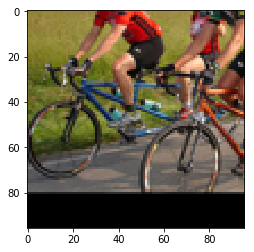

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3 10  1  9  8]
Revised Top 5: [10  3  9  8  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.5315460e-05 2.0333959e-03 4.1851396e-05 2.9291038e-03
 1.9939711e-04 2.7897261e-02 1.5116647e-03 9.6533096e-01 5.0020490e-06
 3.5873592e-05]
Openmax valuess:  [2.88202248e-04 6.84711393e-03 7.44440823e-03 3.72263459e-03
 9.81814140e-03 3.77917345e-03 3.85292449e-02 1.01445715e-02
 9.18933177e-01 1.09352657e-04 3.83980172e-04]


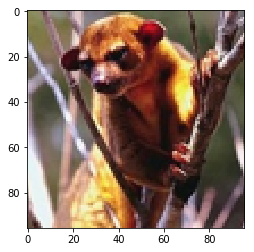

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [8 6 4 2 7]
Revised Top 5: [8 6 7 4 2]
..........................................................................................
Softmax Values:  [0.00000000e+00 4.41102087e-02 4.72916494e-04 8.94809961e-01
 1.42073201e-04 3.59304577e-05 1.04973005e-04 1.45780301e-04
 1.34827176e-04 7.29672983e-03 5.27466200e-02]
Openmax valuess:  [0.37563248 0.03053661 0.02532598 0.09499504 0.01214438 0.00071099
 0.00104368 0.00145986 0.00249463 0.06101821 0.39463813]


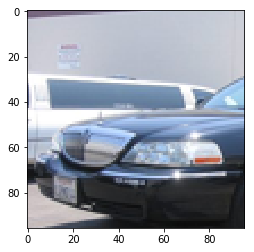

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3 10  1  9  2]
Revised Top 5: [10  0  3  9  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.6302484e-03 1.0688565e-04 2.6683021e-01 1.8236908e-04
 2.0120013e-05 1.2056268e-04 2.6493051e-04 5.7349949e-05 2.0983575e-03
 7.2768891e-01]
Openmax valuess:  [3.18948284e-03 4.05485643e-03 3.08312046e-03 1.12064646e-02
 2.09232937e-03 1.01173054e-04 2.95406282e-04 6.54505496e-04
 2.79891896e-04 4.90301961e-03 9.70139750e-01]


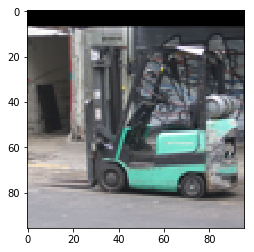

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  1  9  7]
Revised Top 5: [10  3  9  1  0]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.4124429e-03 8.1717908e-01 2.5670175e-02 9.5605832e-03
 2.2652643e-03 9.9428557e-03 6.8317761e-04 1.3193221e-01 2.5792947e-04
 1.0962904e-03]
Openmax valuess:  [0.24586318 0.05970265 0.09269154 0.07202926 0.05882789 0.03290791
 0.05940502 0.00505468 0.36219527 0.00318943 0.00813317]


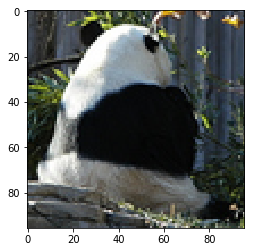

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [2 8 3 6 4]
Revised Top 5: [8 0 2 3 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.4100122e-05 1.0916723e-02 3.9058508e-05 9.5487863e-01
 2.6856437e-03 2.6774863e-02 3.1408152e-04 4.0714792e-03 1.9642264e-04
 1.0894748e-04]
Openmax valuess:  [0.01405742 0.06159977 0.07316326 0.02816642 0.39470955 0.06995475
 0.22801645 0.01296885 0.10297659 0.00980324 0.00458371]


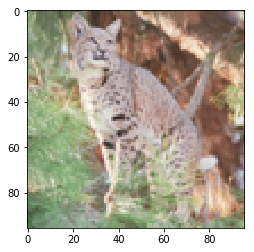

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [4 6 2 8 5]
Revised Top 5: [4 6 8 2 5]
..........................................................................................
Softmax Values:  [0.0000000e+00 8.2517062e-07 6.2680888e-11 9.7024740e-06 3.8300568e-10
 3.7095127e-12 6.2269453e-11 2.3943190e-09 3.0204568e-11 6.4330948e-07
 9.9998879e-01]
Openmax valuess:  [3.12833883e-03 2.35784016e-07 3.42412345e-10 6.95606669e-07
 2.08010091e-09 2.03029311e-11 3.38184605e-10 1.30035151e-08
 1.64040654e-10 2.03770747e-06 9.96868676e-01]


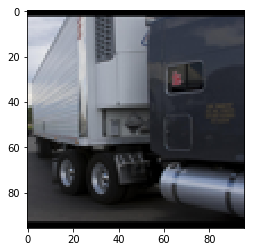

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  1  9  7]
Revised Top 5: [10  0  9  3  1]
..........................................................................................
Softmax Values:  [0.         0.01446154 0.02744915 0.03082644 0.10677344 0.06477938
 0.3645458  0.27807418 0.08513348 0.00894171 0.01901496]
Openmax valuess:  [0.02756626 0.08213608 0.07594846 0.07187582 0.09760436 0.08465196
 0.20233473 0.20597896 0.10484043 0.01789481 0.02916813]


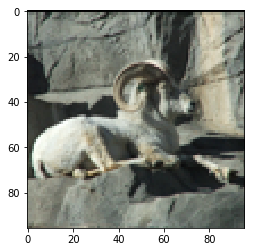

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 7 4 8 5]
Revised Top 5: [7 6 8 4 5]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.7283584e-04 8.1927673e-04 3.1458416e-03 1.4004875e-02
 4.8555015e-03 3.6098638e-01 5.9334242e-01 1.8333819e-02 2.9858286e-04
 3.9404896e-03]
Openmax valuess:  [0.00088658 0.04022195 0.03151792 0.03232312 0.04535249 0.03090028
 0.24943975 0.48412209 0.0642688  0.00254992 0.0184171 ]


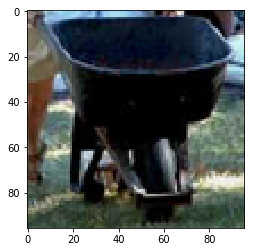

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [7 6 8 4 5]
Revised Top 5: [7 6 8 4 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 4.2689120e-04 2.9793377e-03 1.1495374e-04 5.4640276e-03
 6.4240241e-01 6.9810756e-02 2.5797504e-01 2.0325243e-02 2.4728649e-04
 2.5410860e-04]
Openmax valuess:  [0.00582915 0.0406756  0.03765897 0.01818376 0.03872179 0.25641708
 0.13393923 0.37240523 0.09095294 0.0029983  0.00221796]


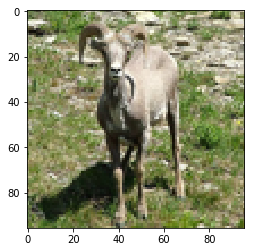

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [5 7 6 8 4]
Revised Top 5: [7 5 6 8 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.6201068e-09 1.2716368e-09 9.9999970e-01 2.4589391e-11
 3.6317825e-14 1.4343801e-11 5.6627806e-12 1.0584902e-11 7.3787171e-11
 2.8820466e-07]
Openmax valuess:  [9.99949888e-01 5.57679263e-07 1.57026727e-07 2.59989065e-05
 3.01985022e-09 4.47988579e-12 1.76157786e-09 6.95452261e-10
 1.29994419e-09 2.06562578e-08 2.33713160e-05]


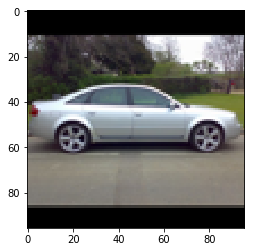

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3 10  1  2  9]
Revised Top 5: [ 0  3 10  1  2]
..........................................................................................
Softmax Values:  [0.0000000e+00 6.4919940e-03 2.5869161e-04 5.8251888e-02 6.4322114e-04
 1.6334426e-04 2.6100475e-04 5.4813857e-04 2.2390614e-04 4.3011162e-02
 8.9014661e-01]
Openmax valuess:  [1.56539118e-03 6.70954369e-03 5.13481014e-03 1.16107782e-02
 3.95239731e-03 6.57525061e-04 4.66598002e-04 9.97567732e-04
 8.55051415e-04 4.72044895e-02 9.20845848e-01]


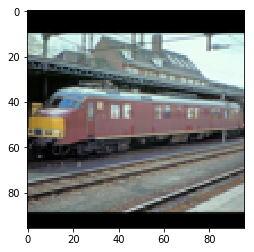

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  9  1  4]
Revised Top 5: [10  9  3  1  2]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.7048260e-04 2.5941967e-03 3.0544910e-04 8.7363124e-02
 9.4925137e-03 7.4450111e-01 6.3771993e-02 9.0826422e-02 3.7683969e-04
 5.9785909e-04]
Openmax valuess:  [0.00183332 0.04257079 0.03775967 0.02183393 0.08532158 0.04427201
 0.39593661 0.14157521 0.22155118 0.00348471 0.00386097]


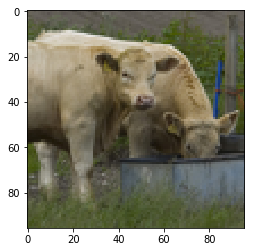

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 8 4 7 5]
Revised Top 5: [6 8 7 4 5]
..........................................................................................
Softmax Values:  [0.0000000e+00 9.6546568e-04 2.8257271e-06 4.2153066e-03 4.7001413e-06
 8.8221367e-07 4.3458326e-06 5.0170689e-05 1.7088397e-06 8.5984642e-04
 9.9389476e-01]
Openmax valuess:  [5.01687485e-04 3.40012663e-04 2.30196975e-04 6.72115515e-04
 5.05893042e-05 3.13702015e-06 1.05799369e-05 1.22257565e-04
 4.80470737e-06 1.45533770e-03 9.96609281e-01]


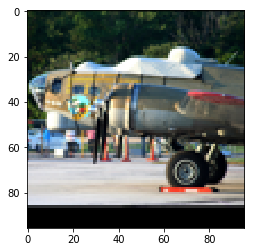

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  1  9  7]
Revised Top 5: [10  9  3  0  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 3.9035402e-04 1.7247550e-01 3.1935267e-02 7.5474143e-01
 1.6885145e-02 3.4881551e-03 3.9784034e-04 1.1944438e-02 1.8666560e-03
 5.8752624e-03]
Openmax valuess:  [0.18060738 0.08273147 0.10624683 0.09738002 0.27285235 0.08883061
 0.04109899 0.00279313 0.07353503 0.01637956 0.03754463]


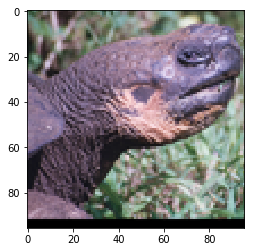

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [4 2 3 5 8]
Revised Top 5: [4 0 2 3 5]
..........................................................................................
Softmax Values:  [0.00000000e+00 3.39731741e-07 3.35235973e-06 9.98138177e-08
 1.17541036e-04 1.09324721e-03 2.30892062e-01 7.67729044e-01
 1.63496676e-04 1.26271999e-07 7.34593868e-07]
Openmax valuess:  [1.41207697e-05 3.15893890e-03 2.31324004e-03 8.38818851e-04
 3.60604649e-03 9.19615383e-03 1.74569268e-01 8.00815559e-01
 5.42011361e-03 1.89558030e-05 4.87846887e-05]


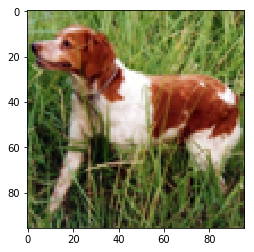

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [7 6 5 8 4]
Revised Top 5: [7 6 5 8 4]
..........................................................................................
Softmax Values:  [0.0000000e+00 3.7478500e-03 1.6183968e-04 2.9200840e-01 2.3154088e-04
 5.6315126e-05 1.0146457e-04 2.9139401e-04 8.8788467e-05 6.5569906e-03
 6.9675541e-01]
Openmax valuess:  [4.66575651e-03 5.51800613e-03 4.23651122e-03 1.45712436e-02
 2.78050403e-03 2.68429631e-04 2.46192140e-04 7.13508201e-04
 4.22558379e-04 1.28732223e-02 9.53704068e-01]


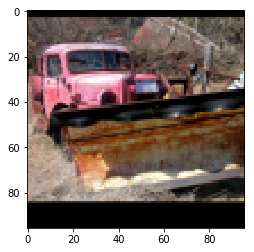

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  9  1  7]
Revised Top 5: [10  3  9  1  0]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.4227665e-03 4.6648874e-04 1.7424780e-01 2.4742442e-03
 5.0153007e-04 2.5975102e-04 4.9969438e-04 4.4770498e-04 1.3316552e-01
 6.8551445e-01]
Openmax valuess:  [2.45750740e-03 1.13578806e-02 8.79522010e-03 2.22669819e-02
 8.70013448e-03 1.94340477e-03 4.90506362e-04 9.60705384e-04
 1.78182221e-03 1.35310999e-01 8.05934838e-01]


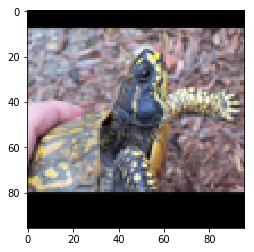

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  9  4  1]
Revised Top 5: [10  9  3  1  2]
..........................................................................................
Softmax Values:  [0.         0.00602487 0.02309792 0.6190761  0.02316141 0.00302033
 0.00200463 0.00191612 0.00227957 0.01291192 0.3065071 ]
Openmax valuess:  [0.07194034 0.04829253 0.04935794 0.09737968 0.05160227 0.02034006
 0.00623861 0.0053963  0.01112285 0.03611028 0.60221914]


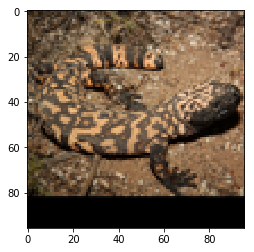

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 3 10  4  2  9]
Revised Top 5: [10  3  0  4  2]
..........................................................................................
Softmax Values:  [0.0000000e+00 9.5125341e-07 8.4305418e-07 1.6241955e-07 2.6750984e-06
 6.3529071e-05 1.2418315e-03 9.9868280e-01 5.1735524e-06 4.2488818e-08
 2.1461849e-06]
Openmax valuess:  [2.05486912e-05 1.21807778e-03 9.17782283e-04 4.97463108e-04
 7.36739986e-04 2.21197592e-03 1.13527701e-02 9.82214030e-01
 5.97972081e-04 1.15911764e-05 2.21048372e-04]


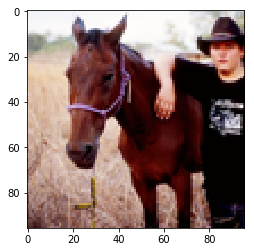

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [7 6 5 8 4]
Revised Top 5: [7 6 5 1 2]
..........................................................................................
Softmax Values:  [0.         0.0260927  0.04556883 0.71474653 0.02044284 0.00264678
 0.00480522 0.00109164 0.00493167 0.13217719 0.04749656]
Openmax valuess:  [0.17925533 0.07954901 0.08280501 0.14947731 0.07054436 0.02316165
 0.01441197 0.00306728 0.02221343 0.2570398  0.11847486]


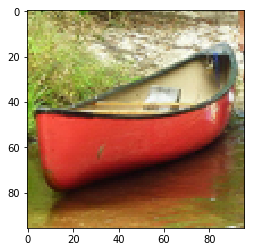

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3  9 10  2  1]
Revised Top 5: [ 9  0  3 10  2]
..........................................................................................
Softmax Values:  [0.         0.719971   0.02668615 0.01824996 0.00325094 0.00387421
 0.00421831 0.00387822 0.00662232 0.159581   0.05366786]
Openmax valuess:  [0.16956097 0.071952   0.07293036 0.06851238 0.03984339 0.03161575
 0.01507122 0.01310964 0.02981317 0.33521467 0.15237644]


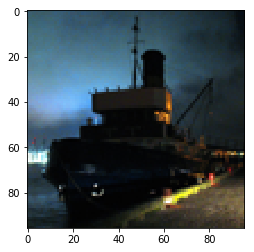

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 1  9 10  2  3]
Revised Top 5: [ 9  0 10  2  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.8913231e-03 5.0797371e-07 5.2766904e-07 6.4880098e-08
 3.4133681e-08 8.2416047e-09 3.4770229e-09 8.1636644e-09 9.9802029e-01
 8.7182438e-05]
Openmax valuess:  [3.49874339e-02 3.59933504e-05 1.76810132e-05 2.55769631e-05
 8.21869511e-07 4.47369225e-07 1.01860522e-07 4.29736494e-08
 1.00920137e-07 9.64164786e-01 7.67013597e-04]


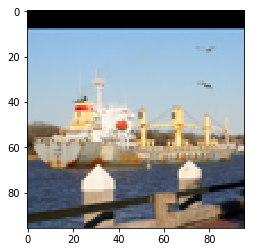

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 9  1 10  3  2]
Revised Top 5: [ 9  0 10  1  3]
..........................................................................................
Softmax Values:  [0.0000000e+00 9.9995494e-01 4.6334585e-06 2.3534859e-08 3.7280790e-10
 8.5340526e-09 1.6017166e-09 1.6548332e-09 9.0635882e-10 3.7363301e-05
 3.0068006e-06]
Openmax valuess:  [9.99992143e-01 1.72885332e-07 2.30789240e-07 9.73688145e-08
 1.55433294e-10 3.72026175e-09 6.66716016e-10 6.88826941e-10
 3.77309230e-10 6.32400168e-06 1.02680900e-06]


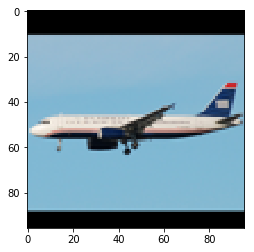

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 1  9  2 10  3]
Revised Top 5: [ 0  9 10  2  1]
..........................................................................................
Softmax Values:  [0.00000000e+00 3.49705510e-06 1.14191775e-04 1.26470752e-06
 3.22040147e-03 2.36128941e-02 7.89480746e-01 1.80261761e-01
 3.29732453e-03 3.82346298e-06 4.02374826e-06]
Openmax valuess:  [2.42788877e-04 1.36515070e-02 1.14153678e-02 3.87855786e-03
 2.17365732e-02 5.63149357e-02 4.64066804e-01 3.87255615e-01
 4.10879616e-02 2.15532480e-04 1.34357147e-04]


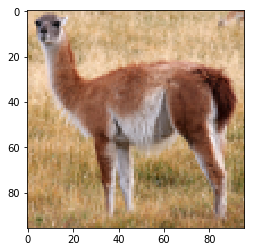

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 7 5 8 4]
Revised Top 5: [6 7 5 8 4]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.1326401e-03 3.5401937e-02 3.4229673e-04 2.1857882e-01
 4.8380607e-01 1.4097564e-01 2.0818681e-02 9.6593522e-02 1.4923075e-03
 8.5799827e-04]
Openmax valuess:  [0.01923888 0.06442392 0.06844187 0.02875224 0.13336612 0.23356278
 0.17397191 0.06737555 0.19866192 0.0083006  0.00390421]


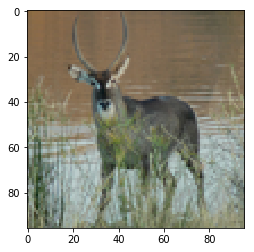

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [5 4 6 8 2]
Revised Top 5: [5 8 6 4 2]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.9721584e-03 1.1752019e-05 3.6854550e-02 2.0913674e-05
 3.2612791e-06 2.1759357e-05 2.8407108e-04 7.5138319e-06 4.0850847e-04
 9.6041554e-01]
Openmax valuess:  [7.88375913e-04 9.51393061e-04 6.64567412e-04 2.32270376e-03
 3.21849045e-04 1.25518542e-05 4.87174054e-05 6.36853659e-04
 2.40570545e-05 9.21856485e-04 9.93307074e-01]


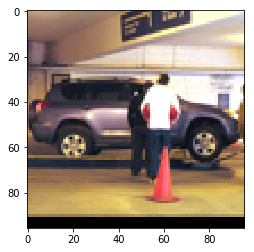

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  1  9  7]
Revised Top 5: [10  3  1  9  0]
..........................................................................................
Softmax Values:  [0.         0.01877086 0.04576289 0.01779171 0.09368111 0.07598395
 0.27687278 0.24200529 0.15407777 0.02243066 0.05262296]
Openmax valuess:  [0.01779844 0.08411769 0.08035979 0.06355228 0.090925   0.08581764
 0.16463723 0.17369327 0.14289143 0.03298845 0.06321879]


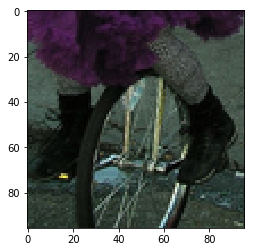

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 7 8 4 5]
Revised Top 5: [7 6 8 4 5]
..........................................................................................
Softmax Values:  [0.0000000e+00 4.5703669e-04 3.6704999e-01 3.1551422e-04 2.0346157e-02
 3.6691400e-04 5.0281160e-02 9.4447617e-04 5.6008112e-01 6.0022692e-05
 9.7634555e-05]
Openmax valuess:  [0.03558775 0.02531252 0.0393227  0.0148871  0.03984615 0.00930043
 0.08476474 0.0064183  0.74294924 0.00080292 0.00080816]


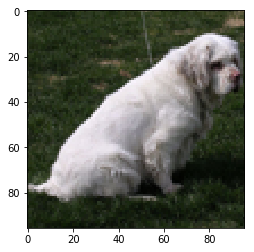

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [8 2 6 4 7]
Revised Top 5: [8 6 4 2 0]
..........................................................................................
Softmax Values:  [0.0000000e+00 5.7695727e-03 3.1967330e-04 6.5839718e-05 2.1568754e-04
 5.7555655e-05 3.8561247e-05 9.6860731e-06 5.6137113e-05 9.9200869e-01
 1.4585848e-03]
Openmax valuess:  [1.95510178e-03 2.47939363e-03 2.34382637e-03 1.61533169e-03
 1.86131961e-03 5.05055961e-04 1.70465004e-04 4.32489267e-05
 4.40763756e-04 9.82725895e-01 5.85959850e-03]


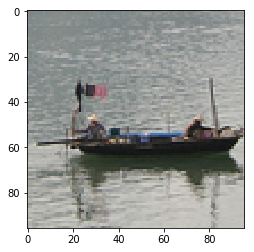

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 9  1 10  2  4]
Revised Top 5: [ 9 10  1  2  0]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.3992052e-05 4.4559534e-03 3.8603626e-05 6.3965422e-01
 7.6157525e-03 3.1725955e-01 3.3326983e-03 2.7344704e-02 1.6074796e-04
 1.1394253e-04]
Openmax valuess:  [0.00239845 0.04468812 0.04530692 0.01776947 0.20663831 0.0585047
 0.40391629 0.04020716 0.17520725 0.00349732 0.00186601]


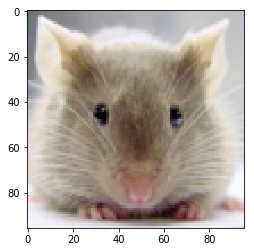

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [4 6 8 5 2]
Revised Top 5: [6 4 8 5 2]
..........................................................................................
Softmax Values:  [0.         0.00120269 0.6502161  0.02319519 0.10165711 0.03039318
 0.008069   0.00119877 0.17755376 0.00099178 0.0055225 ]
Openmax valuess:  [0.191563   0.06731423 0.09538818 0.06939853 0.10977257 0.07971588
 0.04284757 0.00534839 0.31132275 0.00610792 0.02122099]


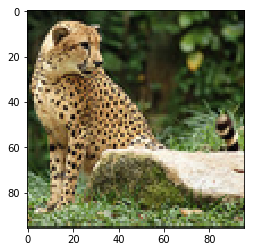

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [2 8 4 5 3]
Revised Top 5: [8 0 4 2 5]
..........................................................................................
Softmax Values:  [0.0000000e+00 9.9688751e-01 2.6236076e-03 5.0997419e-06 1.0051702e-06
 1.2873906e-05 3.7647212e-06 1.9089330e-06 2.5825282e-06 4.0611532e-04
 5.5556633e-05]
Openmax valuess:  [9.94670742e-01 6.49408119e-04 9.26170908e-04 3.78960914e-04
 1.43378334e-04 1.59197991e-04 3.24403739e-05 1.65139751e-05
 3.09860789e-05 2.49865032e-03 4.93550756e-04]


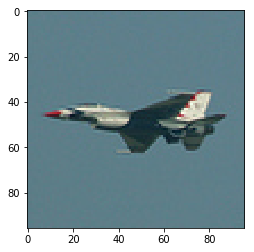

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 1  2  9 10  5]
Revised Top 5: [ 0  9  2  1 10]
..........................................................................................
Softmax Values:  [0.0000000e+00 4.8948468e-06 1.0594952e-06 9.9989444e-01 5.1466888e-08
 5.1791843e-10 2.5787696e-08 1.5204943e-08 2.3435010e-08 5.1620964e-07
 9.8982433e-05]
Openmax valuess:  [9.98080104e-01 4.61113347e-05 4.12354889e-05 6.03101782e-04
 9.77889053e-07 1.00278616e-08 4.55177386e-07 2.68383978e-07
 4.18539013e-07 1.26019268e-05 1.21471506e-03]


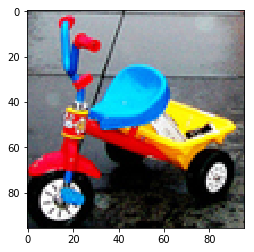

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3 10  1  2  9]
Revised Top 5: [ 0 10  3  1  2]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.2108475e-04 7.2296761e-04 8.9002504e-05 1.3476302e-03
 4.7322265e-03 9.9561110e-02 8.9215308e-01 8.4007916e-04 3.1103300e-05
 3.0180361e-04]
Openmax valuess:  [2.60468712e-03 1.88620962e-02 1.71228551e-02 1.02239587e-02
 1.70092121e-02 2.71589852e-02 1.36460368e-01 7.55613377e-01
 1.06447264e-02 7.02149949e-04 3.59758473e-03]


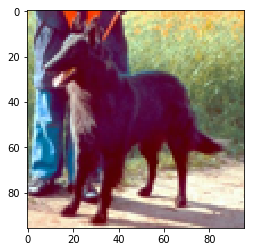

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [7 6 5 4 8]
Revised Top 5: [7 6 5 1 2]
..........................................................................................
Softmax Values:  [0.00000000e+00 4.79360053e-04 7.77932146e-05 8.80639076e-01
 7.01167955e-05 7.21219112e-06 2.51233923e-05 2.73222813e-05
 4.22487101e-05 4.10397211e-03 1.14527695e-01]
Openmax valuess:  [3.25605147e-02 9.87108925e-03 7.82530368e-03 4.01244015e-02
 4.76691652e-03 1.49766309e-04 3.12509265e-04 3.40785718e-04
 8.11030187e-04 3.67505807e-02 8.66487102e-01]


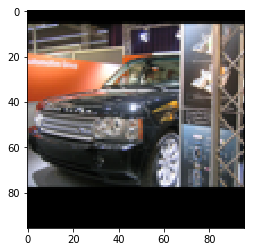

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 3 10  9  1  2]
Revised Top 5: [10  3  9  0  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.3848323e-06 3.7106573e-09 6.5963435e-09 7.6122966e-09
 2.9801178e-10 1.8764777e-10 1.6116726e-11 1.6260406e-10 9.9999565e-01
 2.9418507e-06]
Openmax valuess:  [2.01904961e-04 1.68069128e-06 1.32693852e-07 1.07881932e-06
 2.11632042e-07 8.49322577e-09 5.20993079e-09 4.47471491e-10
 4.51465212e-09 9.99739581e-01 5.53919953e-05]


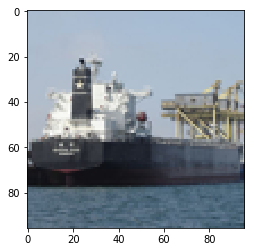

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 9 10  1  4  3]
Revised Top 5: [ 9  0 10  1  3]
..........................................................................................
Softmax Values:  [0.         0.02422997 0.32504702 0.00362003 0.08931941 0.0549791
 0.36129183 0.06214871 0.06537526 0.00800718 0.0059814 ]
Openmax valuess:  [0.12924115 0.07985424 0.09732323 0.048249   0.0981191  0.08655114
 0.22638452 0.0974029  0.10378987 0.02008506 0.01299979]


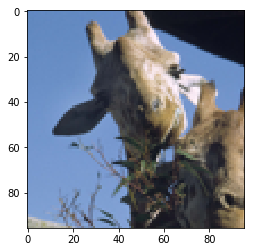

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 2 4 8 7]
Revised Top 5: [6 0 8 4 7]
..........................................................................................
Softmax Values:  [0.         0.00055727 0.03166713 0.0009397  0.21183747 0.55115896
 0.03049575 0.01242614 0.15856212 0.0009545  0.00140086]
Openmax valuess:  [0.0158406  0.06220594 0.06611297 0.03477103 0.13207317 0.24883902
 0.08277922 0.05046707 0.29425866 0.00614901 0.00650331]


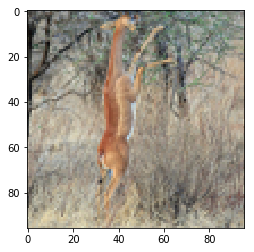

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [5 4 8 2 6]
Revised Top 5: [8 5 4 6 2]
..........................................................................................
Softmax Values:  [0.0000000e+00 5.3467141e-07 6.4242215e-08 4.8493471e-06 3.5084429e-07
 8.2246748e-05 2.0378856e-04 9.9966466e-01 3.3583103e-06 7.7166796e-08
 4.0053099e-05]
Openmax valuess:  [7.03521336e-07 1.33198975e-03 7.64135487e-04 1.04090813e-03
 3.74368595e-04 2.52405093e-03 9.43045368e-03 9.81156054e-01
 4.22536678e-04 1.80944217e-05 2.93670495e-03]


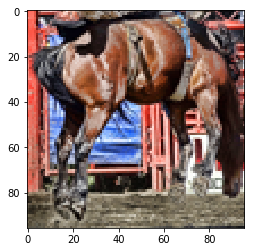

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 7  6  5 10  3]
Revised Top 5: [ 7  6 10  5  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 9.6673661e-01 6.2796511e-03 1.1107110e-03 2.5014026e-04
 1.5298411e-03 6.1068148e-04 1.4837395e-03 4.1992468e-04 1.3555334e-02
 8.0233989e-03]
Openmax valuess:  [0.42010335 0.06376992 0.06660339 0.04919374 0.02762687 0.04049585
 0.00995292 0.0245537  0.013015   0.16710877 0.1175765 ]


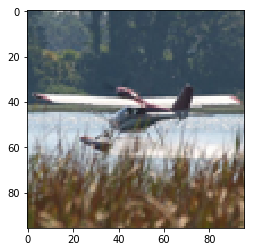

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 1  9 10  2  5]
Revised Top 5: [ 0  9 10  2  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.1065110e-03 6.0871063e-04 1.3548067e-01 8.0695795e-03
 2.3180677e-04 3.7924675e-04 2.3743461e-04 2.2364753e-04 4.0209952e-01
 4.5056295e-01]
Openmax valuess:  [3.61255909e-03 1.32072485e-02 1.03892155e-02 2.40905355e-02
 1.39590406e-02 1.04986158e-03 7.46584101e-04 4.72877390e-04
 1.08861505e-03 3.49070964e-01 5.82312499e-01]


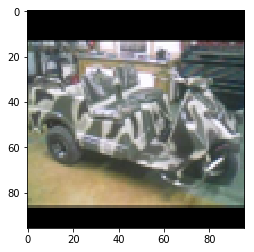

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  9  3  4  1]
Revised Top 5: [10  9  3  4  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.4416012e-03 4.5568439e-05 5.4585310e-03 1.8743673e-04
 2.9628360e-05 8.8050001e-05 5.0780858e-04 6.9577953e-05 5.9808693e-03
 9.8619092e-01]
Openmax valuess:  [1.18125543e-04 2.00562606e-03 1.47101263e-03 2.80973371e-03
 1.20950155e-03 1.43355021e-04 1.74615525e-04 1.01702858e-03
 2.79407517e-04 8.31115876e-03 9.82460435e-01]


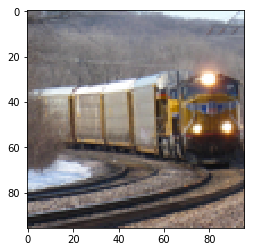

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  9  3  1  7]
Revised Top 5: [10  9  3  1  2]
..........................................................................................
Softmax Values:  [0.         0.00264551 0.7471235  0.01638758 0.04834712 0.00167066
 0.0111274  0.00109737 0.16465019 0.00163689 0.00531385]
Openmax valuess:  [0.18625514 0.06773933 0.0998075  0.06850306 0.09530183 0.02779253
 0.05740545 0.00586639 0.35425489 0.01121815 0.02585572]


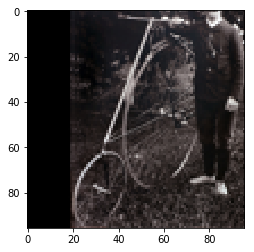

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [2 8 4 3 6]
Revised Top 5: [8 0 2 4 3]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.3510588e-01 1.6703553e-04 1.8325631e-03 5.4820328e-05
 1.9128098e-05 1.7170722e-05 3.0223355e-05 2.0229587e-05 6.7023081e-01
 1.9252209e-01]
Openmax valuess:  [5.15219530e-02 3.85657461e-03 3.14897853e-03 4.15133396e-03
 1.01303902e-03 8.42509912e-05 5.22229088e-05 9.20073134e-05
 6.98833032e-05 5.81671594e-01 3.54338163e-01]


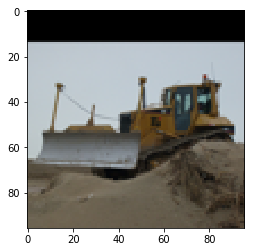

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 9 10  1  3  2]
Revised Top 5: [ 9 10  0  3  1]
..........................................................................................
Softmax Values:  [0.         0.00104332 0.00657809 0.00299475 0.0829217  0.11538946
 0.4103462  0.19050312 0.18584901 0.0014659  0.00290834]
Openmax valuess:  [0.00424803 0.05838946 0.05078354 0.03773667 0.0821619  0.10507877
 0.22951034 0.19043502 0.22792725 0.00575236 0.00797666]


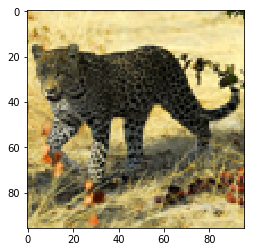

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 7 8 5 4]
Revised Top 5: [6 8 7 5 4]
..........................................................................................
Softmax Values:  [0.0000000e+00 7.2318602e-05 5.1065511e-03 4.0647649e-04 2.1779105e-02
 2.0690088e-04 9.6033111e-02 2.1918647e-03 8.7389570e-01 5.1697971e-05
 2.5630803e-04]
Openmax valuess:  [9.03037267e-04 1.56487835e-02 1.64749646e-02 1.04556239e-02
 2.82153873e-02 5.33224482e-03 8.77701392e-02 1.21497359e-02
 8.20767728e-01 5.99112693e-04 1.68324318e-03]


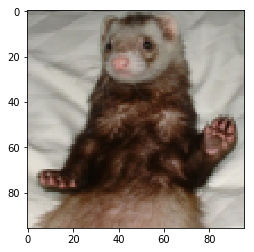

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [8 6 4 2 7]
Revised Top 5: [8 6 4 2 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 4.5319507e-03 1.0242657e-03 5.0490469e-02 7.1889809e-03
 2.9560896e-03 7.0067716e-04 1.3310174e-03 5.6351768e-04 1.8254979e-01
 7.4866325e-01]
Openmax valuess:  [0.0018319  0.01530921 0.01222202 0.02127615 0.01397657 0.0079639
 0.00112058 0.00218813 0.00208273 0.15968036 0.76234845]


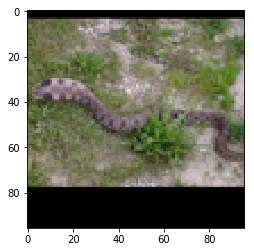

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  9  3  4  1]
Revised Top 5: [10  9  3  1  4]
..........................................................................................
Softmax Values:  [0.0000000e+00 7.5383717e-03 8.8894507e-04 1.7670214e-02 1.0260563e-02
 1.7212548e-03 3.8235038e-04 3.5960463e-04 2.7181781e-04 8.1151384e-01
 1.4939305e-01]
Openmax valuess:  [0.00384739 0.01625373 0.01311597 0.01924513 0.01779031 0.00672183
 0.00082184 0.00079248 0.00156249 0.68244488 0.23740395]


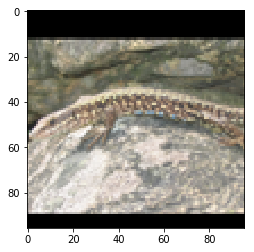

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 9 10  3  4  1]
Revised Top 5: [ 9 10  3  4  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 9.1615857e-06 7.6383512e-05 1.1905827e-06 1.3558861e-04
 3.6606267e-01 2.0011118e-02 6.1351162e-01 1.8379219e-04 2.9337980e-06
 5.5221381e-06]
Openmax valuess:  [5.73906271e-04 8.74343018e-03 7.49280118e-03 2.79356357e-03
 6.53636065e-03 1.39879355e-01 6.54077961e-02 7.62693261e-01
 5.48715914e-03 1.87467166e-04 2.04899064e-04]


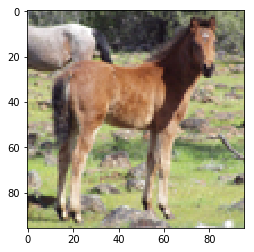

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [7 5 6 8 4]
Revised Top 5: [7 5 6 1 2]
..........................................................................................
Softmax Values:  [0.0000000e+00 5.1323868e-02 2.4960601e-01 2.3491569e-03 4.9061715e-03
 1.3818264e-03 1.6709148e-04 1.4877770e-05 3.7113455e-04 6.8734771e-01
 2.5321669e-03]
Openmax valuess:  [4.85857055e-01 1.09033131e-02 1.57207121e-02 8.91491792e-03
 1.00541645e-02 4.11912560e-03 2.83452213e-04 2.54237014e-05
 1.47100398e-03 4.57936766e-01 4.71406578e-03]


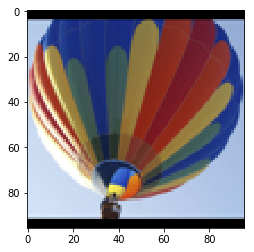

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 9  2  1  4 10]
Revised Top 5: [0 9 2 1 4]
..........................................................................................
Softmax Values:  [0.00000000e+00 8.06482785e-06 1.87215235e-04 2.80106497e-06
 3.75961931e-03 9.27742422e-01 1.79787707e-02 4.98226956e-02
 4.77234571e-04 1.19781325e-05 9.17057514e-06]
Openmax valuess:  [0.00224855 0.02420663 0.02130611 0.00809227 0.04059612 0.43676525
 0.12531204 0.32092594 0.01907201 0.00096679 0.00050829]


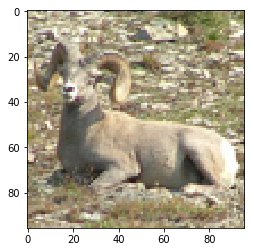

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [5 7 6 4 8]
Revised Top 5: [5 7 6 4 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 5.3391130e-07 6.6419278e-05 2.7959680e-07 1.6638821e-02
 1.0199293e-02 9.5878714e-01 1.3314412e-02 9.9007168e-04 2.0330813e-06
 9.1860795e-07]
Openmax valuess:  [1.68662813e-04 1.31520924e-02 1.12438419e-02 3.21871274e-03
 4.30926304e-02 5.26241058e-02 7.21619512e-01 1.25488247e-01
 2.90934167e-02 2.30697213e-04 6.80810420e-05]


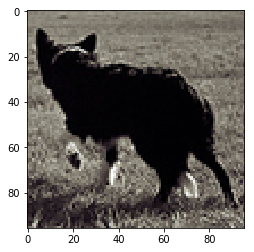

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [6 4 7 5 8]
Revised Top 5: [6 7 5 4 8]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.9720638e-03 1.3160845e-03 8.4526074e-01 2.2814213e-03
 1.0297475e-04 1.1996669e-03 6.7760999e-04 6.2834675e-04 5.8072237e-03
 1.3975389e-01]
Openmax valuess:  [0.03010575 0.03919547 0.03384597 0.10649257 0.02976634 0.00249708
 0.00831544 0.00482251 0.00836323 0.03973305 0.69686259]


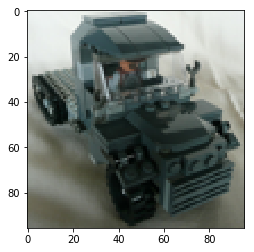

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 3 10  9  1  4]
Revised Top 5: [10  3  9  1  2]
..........................................................................................
Softmax Values:  [0.         0.02587701 0.5693866  0.00348467 0.20096366 0.04517509
 0.05103628 0.00658912 0.04954907 0.04254394 0.00539465]
Openmax valuess:  [0.17033793 0.0907317  0.1177523  0.05514811 0.14511195 0.09341082
 0.10001075 0.01967555 0.1018524  0.09166135 0.01430714]


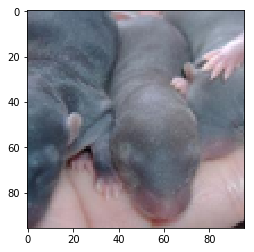

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [2 4 6 8 5]
Revised Top 5: [0 4 2 8 6]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.5468648e-04 1.9949218e-02 7.1550795e-04 3.1143084e-01
 2.6408937e-02 4.5682054e-02 4.6897419e-03 5.8974439e-01 3.6916285e-04
 8.5542671e-04]
Openmax valuess:  [0.0050207  0.03739083 0.0399109  0.02189555 0.10369917 0.05430015
 0.07839843 0.02106187 0.63178168 0.00258947 0.00395125]


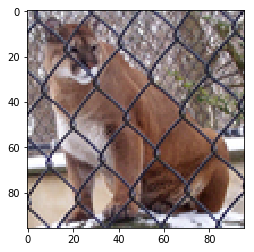

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [8 4 6 5 2]
Revised Top 5: [8 4 6 5 2]
..........................................................................................
Softmax Values:  [0.0000000e+00 5.1825074e-03 9.1879416e-01 1.4300375e-03 1.6991114e-02
 3.0636795e-02 5.0617256e-03 1.2714486e-03 1.8845104e-02 9.7283506e-04
 8.1430253e-04]
Openmax valuess:  [0.57512589 0.04629761 0.07387163 0.03234616 0.05680899 0.07699192
 0.03553812 0.0091222  0.08023775 0.00810529 0.00555446]


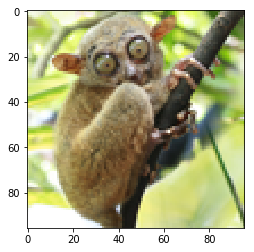

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [2 5 8 4 1]
Revised Top 5: [0 8 5 2 4]
..........................................................................................
Softmax Values:  [0.0000000e+00 3.8009646e-05 8.0270050e-03 1.7507271e-04 3.3604395e-01
 4.4199508e-03 6.3005358e-01 6.4377184e-03 1.4483991e-02 1.7543962e-04
 1.4529872e-04]
Openmax valuess:  [0.0043723  0.04552957 0.04783848 0.02338806 0.16191902 0.04370937
 0.51656477 0.05428115 0.09730044 0.00317558 0.00192126]


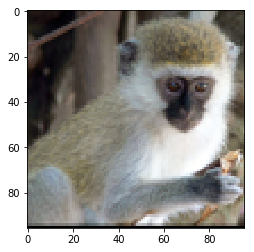

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [6 4 8 2 7]
Revised Top 5: [6 4 8 7 2]
..........................................................................................
Softmax Values:  [0.         0.00158984 0.02416268 0.00210345 0.08514281 0.00097878
 0.29761425 0.00797561 0.5762632  0.00168593 0.00248348]
Openmax valuess:  [0.00611446 0.04283547 0.04497762 0.02898322 0.07235742 0.01444081
 0.19187672 0.02719733 0.55511992 0.00752145 0.00857557]


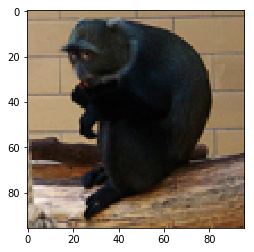

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [8 6 4 2 7]
Revised Top 5: [8 6 4 2 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.8190187e-04 7.9212293e-07 4.3855011e-06 1.6914897e-06
 1.3972982e-07 1.0837413e-07 2.4243965e-08 9.7598978e-08 9.9933594e-01
 4.7485417e-04]
Openmax valuess:  [7.41946446e-04 1.00002098e-04 7.75684182e-05 8.47239291e-05
 2.63263689e-05 1.64788168e-06 1.07869934e-06 2.41320314e-07
 9.84222558e-07 9.95751210e-01 3.21427056e-03]


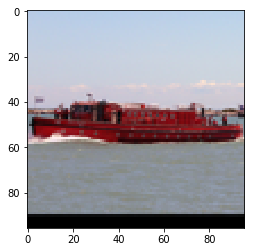

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 9 10  1  3  4]
Revised Top 5: [ 9 10  0  1  3]
..........................................................................................
Softmax Values:  [0.         0.00190828 0.04781172 0.00287121 0.4282102  0.37483108
 0.06127453 0.02075645 0.05271014 0.00402684 0.00559951]
Openmax valuess:  [0.03360372 0.08138676 0.08547186 0.05114446 0.18196955 0.22560661
 0.11769921 0.06535783 0.12276975 0.01663616 0.01835408]


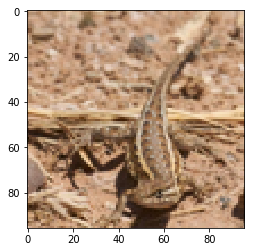

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [4 5 6 8 2]
Revised Top 5: [5 4 8 6 2]
..........................................................................................
Softmax Values:  [0.         0.00083578 0.01977576 0.00226669 0.08765162 0.00803358
 0.13151179 0.01406448 0.7327535  0.00092003 0.00218672]
Openmax valuess:  [0.00568021 0.04113016 0.0421518  0.02801069 0.06920153 0.03164417
 0.11990986 0.03865303 0.61224882 0.00430074 0.00706898]


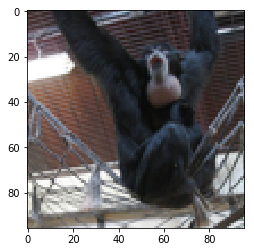

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [8 6 4 2 7]
Revised Top 5: [8 6 4 2 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 9.4649011e-01 1.7143771e-03 5.0496869e-03 1.5609011e-04
 2.7119456e-04 2.0945595e-04 5.3981226e-04 1.9960754e-04 2.6644491e-02
 1.8725181e-02]
Openmax valuess:  [0.3808025  0.04495741 0.04197866 0.04865052 0.01783462 0.0081534
 0.00276826 0.0073152  0.00568018 0.23324943 0.20860982]


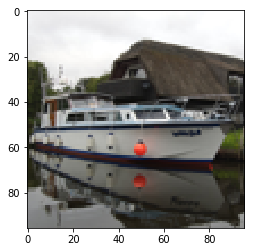

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 1  9 10  3  2]
Revised Top 5: [ 0  9 10  3  1]
..........................................................................................
Softmax Values:  [0.00000000e+00 1.71581581e-02 5.02046198e-04 5.97409708e-05
 1.44178775e-05 3.67058055e-05 3.76646267e-06 4.07208609e-06
 8.45539853e-06 9.79326844e-01 2.88581150e-03]
Openmax valuess:  [1.82947758e-02 1.44618405e-03 1.52847209e-03 1.05535162e-03
 5.88535546e-04 2.55109217e-04 1.88691801e-05 2.04304515e-05
 5.24978793e-05 9.65255569e-01 1.14842052e-02]


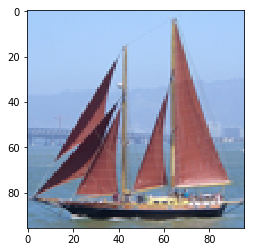

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 9  1 10  2  3]
Revised Top 5: [ 9  0 10  2  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.1324265e-01 2.2644820e-03 8.5793380e-03 7.6174532e-04
 3.6053604e-04 8.4054784e-04 3.5812489e-03 3.5969546e-04 1.6738966e-02
 8.5327083e-01]
Openmax valuess:  [0.0064907  0.01106307 0.00998966 0.01177396 0.00587425 0.00186753
 0.00149141 0.00643415 0.00149374 0.02422601 0.91929551]


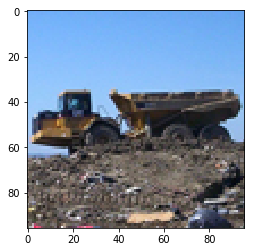

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  1  9  3  7]
Revised Top 5: [10  9  3  1  2]
..........................................................................................
Softmax Values:  [0.         0.40653095 0.01908056 0.00848109 0.02065882 0.01538195
 0.02559775 0.02378313 0.00994717 0.33845928 0.13207927]
Openmax valuess:  [0.01694932 0.07443357 0.06816542 0.05308008 0.0585476  0.04803061
 0.05312252 0.04230547 0.02548659 0.36750515 0.19237368]


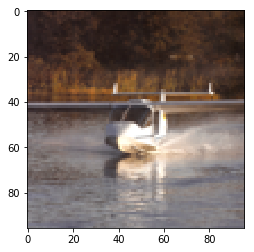

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 1  9 10  6  7]
Revised Top 5: [ 9 10  1  2  4]
..........................................................................................
Softmax Values:  [0.         0.00075576 0.01462535 0.00260112 0.55195606 0.06336749
 0.2835207  0.05740625 0.01673321 0.00366323 0.00537087]
Openmax valuess:  [0.01076244 0.07602306 0.0723489  0.04874492 0.19473523 0.11209745
 0.26128678 0.12828519 0.05905851 0.01689834 0.01975918]


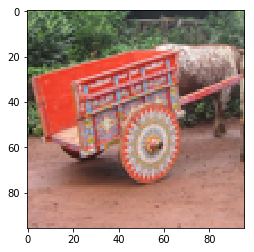

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [4 6 5 7 8]
Revised Top 5: [6 4 7 5 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.2086769e-04 1.6661765e-07 3.8110935e-05 1.6102529e-06
 9.1430557e-08 6.8150783e-08 4.1915065e-08 5.0321326e-08 9.9176508e-01
 8.0738803e-03]
Openmax valuess:  [3.23731964e-03 1.19199716e-04 1.79446809e-05 1.47718981e-04
 1.64458332e-05 9.18808172e-07 6.23019832e-07 3.83181400e-07
 4.60871283e-07 9.57650246e-01 3.88087396e-02]


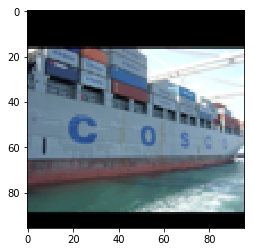

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 9 10  1  3  4]
Revised Top 5: [ 9 10  0  3  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.1119866e-08 6.0376075e-13 2.9141502e-06 8.1630614e-12
 1.1091328e-13 1.5077080e-12 8.4585464e-11 4.9868042e-13 1.0903008e-06
 9.9999601e-01]
Openmax valuess:  [4.39047528e-04 2.16973827e-08 4.28711787e-12 8.55634035e-08
 5.79631517e-11 7.88255743e-13 1.07057262e-11 6.00612882e-10
 3.54096146e-12 2.38977844e-06 9.99558455e-01]


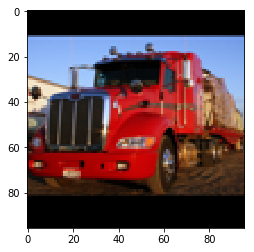

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  9  1  7]
Revised Top 5: [10  0  9  3  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 3.8323606e-06 3.6612062e-07 9.9990821e-01 3.4964163e-08
 5.7586075e-10 2.4178215e-08 2.2164505e-08 2.7300167e-08 2.0764951e-07
 8.7234104e-05]
Openmax valuess:  [9.95986919e-01 9.08912238e-05 6.90114191e-05 1.24101082e-03
 1.62517954e-06 2.74091968e-08 1.04292747e-06 9.56079025e-07
 1.19346462e-06 1.42374774e-05 2.59308510e-03]


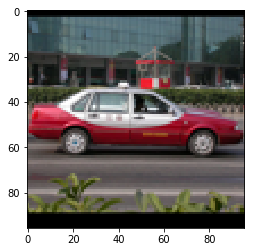

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3 10  1  2  9]
Revised Top 5: [ 0 10  3  1  2]
..........................................................................................
Softmax Values:  [0.0000000e+00 3.0356425e-05 1.0900438e-04 1.2680099e-05 1.3905400e-03
 1.4525528e-01 9.3037926e-02 7.5935560e-01 7.4803270e-04 2.1191976e-05
 3.9430062e-05]
Openmax valuess:  [5.60356845e-04 1.51849373e-02 1.18881332e-02 6.05271270e-03
 1.56400034e-02 1.01412347e-01 1.30474104e-01 7.06997213e-01
 1.05402586e-02 5.78096433e-04 6.71837276e-04]


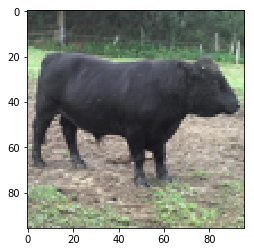

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [7 5 6 4 8]
Revised Top 5: [7 6 5 4 1]
..........................................................................................
Softmax Values:  [0.         0.03686838 0.07247142 0.14440005 0.35239735 0.06415185
 0.06440403 0.02222778 0.03398864 0.12564579 0.08344469]
Openmax valuess:  [0.04516179 0.10384762 0.10118692 0.11317026 0.15439733 0.08915072
 0.08598226 0.03175638 0.05096925 0.13104007 0.09333741]


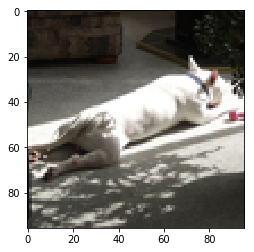

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 4  3  9 10  2]
Revised Top 5: [4 9 3 1 2]
..........................................................................................
Softmax Values:  [0.0000000e+00 4.7583182e-04 5.7448670e-02 2.5667457e-03 1.1568617e-01
 1.0454936e-02 2.1304362e-02 2.1768727e-03 7.8725791e-01 5.7698169e-04
 2.0514780e-03]
Openmax valuess:  [0.01410972 0.03665704 0.04300696 0.02709821 0.0730301  0.03513172
 0.0496202  0.00950594 0.70083031 0.00331676 0.00769304]


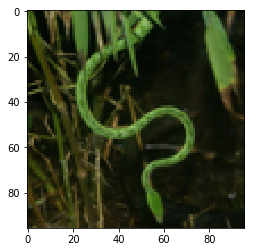

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [8 4 2 6 5]
Revised Top 5: [8 4 6 2 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 4.7074049e-04 3.2334311e-03 3.0181001e-04 2.0579968e-02
 3.3077724e-02 4.1938421e-01 4.5614108e-01 6.6030294e-02 2.2484554e-04
 5.5592356e-04]
Openmax valuess:  [0.00293971 0.0385307  0.03451854 0.01924473 0.04827005 0.06291261
 0.25322619 0.38809784 0.14742839 0.00189473 0.00293652]


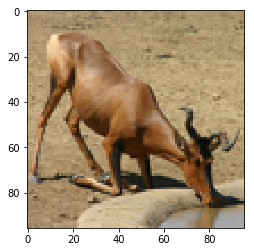

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [7 6 8 5 4]
Revised Top 5: [7 6 8 5 4]
..........................................................................................
Softmax Values:  [0.0000000e+00 8.5429841e-01 4.1169743e-03 6.3566134e-05 3.3271634e-05
 3.5455680e-05 2.2924874e-05 4.5155607e-06 2.1134110e-05 1.4102599e-01
 3.7780986e-04]
Openmax valuess:  [6.73720342e-01 4.16438068e-03 5.01140586e-03 2.61877544e-03
 1.71012038e-03 3.80087443e-04 1.47696684e-04 2.91597881e-05
 1.92541731e-04 3.09457115e-01 2.56837475e-03]


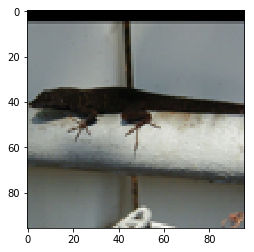

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 1  9  2 10  3]
Revised Top 5: [0 9 2 1 3]
..........................................................................................
Softmax Values:  [0.0000000e+00 3.7274273e-07 2.0260075e-03 4.0418458e-06 9.9075830e-01
 4.9573660e-04 1.7157429e-03 9.7478969e-06 4.9670250e-03 9.8200608e-06
 1.3263174e-05]
Openmax valuess:  [0.00899539 0.0385659  0.04702943 0.01653955 0.44822929 0.04856378
 0.09570625 0.00150193 0.28972496 0.00265407 0.00248946]


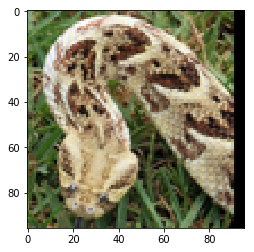

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [4 8 2 6 5]
Revised Top 5: [4 8 6 5 2]
..........................................................................................
Softmax Values:  [0.         0.01230825 0.00536774 0.8330986  0.01834668 0.0010013
 0.00696476 0.0050872  0.00274186 0.03485017 0.08023347]
Openmax valuess:  [0.0262041  0.09119894 0.07928591 0.18905289 0.08664399 0.0195386
 0.03557458 0.02310729 0.02139001 0.13291402 0.29508966]


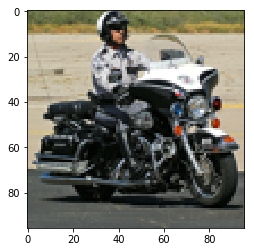

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3 10  9  4  1]
Revised Top 5: [10  3  9  1  4]
..........................................................................................
Softmax Values:  [0.0000000e+00 7.0341671e-06 1.5792244e-03 1.2953462e-05 2.8714189e-01
 1.8702382e-03 7.0238584e-01 1.9531520e-03 4.9641500e-03 5.2531101e-05
 3.3017131e-05]
Openmax valuess:  [0.00107533 0.03109494 0.03095613 0.01179213 0.14613578 0.03268128
 0.64126973 0.03491961 0.06718457 0.00197117 0.00091932]


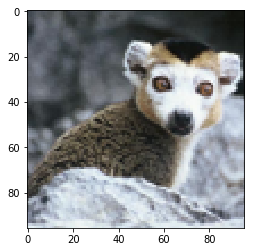

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [6 4 8 7 5]
Revised Top 5: [6 4 8 7 5]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.7900053e-06 3.8168294e-04 1.7702059e-06 3.5557852e-03
 9.9411809e-01 9.3851506e-04 8.4965600e-04 1.4552880e-04 3.6853962e-06
 3.4850577e-06]
Openmax valuess:  [8.00322094e-03 2.51221631e-02 2.66323091e-02 9.63884130e-03
 5.84631554e-02 7.37493675e-01 5.27454808e-02 6.10536586e-02
 1.92482789e-02 9.78805769e-04 6.20411262e-04]


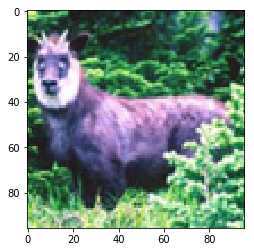

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [5 4 6 7 2]
Revised Top 5: [5 7 4 6 2]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.1375132e-05 1.4737582e-06 9.9892759e-01 2.2101443e-07
 6.0322165e-09 1.0318656e-07 1.1717753e-07 1.3863423e-07 3.7756131e-06
 1.0551808e-03]
Openmax valuess:  [9.62471717e-01 4.46625465e-04 3.71930342e-04 4.54152072e-03
 1.42871109e-05 3.39007595e-07 5.01558610e-06 5.69589975e-06
 6.97282269e-06 2.19248950e-04 3.19166473e-02]


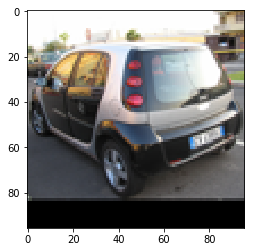

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3 10  1  9  2]
Revised Top 5: [ 0 10  3  1  2]
..........................................................................................
Softmax Values:  [0.         0.00613082 0.00117132 0.07127638 0.00157197 0.00111342
 0.00148687 0.00913925 0.00187556 0.00948986 0.89674455]
Openmax valuess:  [0.00095352 0.01359634 0.01115637 0.02081983 0.00820453 0.0048765
 0.00269403 0.01458322 0.00473417 0.01489682 0.90348466]


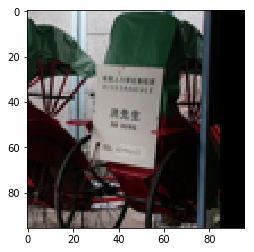

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  9  7  1]
Revised Top 5: [10  3  9  7  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.4952084e-07 1.1220796e-07 9.9999404e-01 3.8528971e-09
 1.6300598e-11 1.8289500e-09 6.1093824e-10 1.8572142e-09 1.9645306e-08
 5.7506527e-06]
Openmax valuess:  [9.99466909e-01 1.30627934e-05 8.41529188e-06 2.76706470e-04
 2.15506588e-07 9.44559443e-10 1.01895916e-07 3.40370968e-08
 1.03599471e-07 1.79712466e-06 2.32652905e-04]


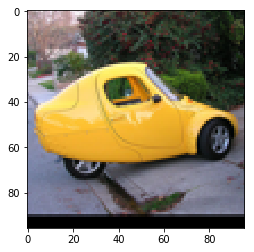

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3 10  1  2  9]
Revised Top 5: [ 0  3 10  1  2]
..........................................................................................
Softmax Values:  [0.         0.00069953 0.02348776 0.00125865 0.14237456 0.17681126
 0.08837937 0.03227907 0.5316934  0.00100551 0.00201092]
Openmax valuess:  [0.00740328 0.04993207 0.05050304 0.02844907 0.08870959 0.11716517
 0.10252357 0.06477695 0.48008558 0.00439663 0.00605505]


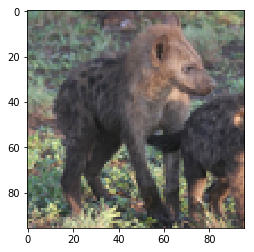

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [8 5 4 6 7]
Revised Top 5: [8 5 6 4 7]
..........................................................................................
Softmax Values:  [0.0000000e+00 5.0768208e-02 4.5926363e-04 9.7713312e-03 6.2508229e-04
 3.6820531e-04 1.8994910e-04 4.7386857e-04 2.0495111e-04 6.0279197e-01
 3.3434719e-01]
Openmax valuess:  [5.54013296e-03 1.04320021e-02 8.23053617e-03 1.19692494e-02
 5.61967984e-03 1.51338514e-03 4.03232208e-04 1.01889897e-03
 8.34670842e-04 4.89030185e-01 4.65408027e-01]


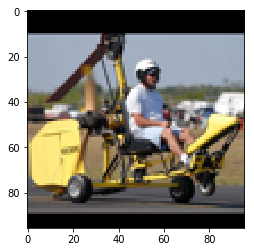

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 9 10  1  3  4]
Revised Top 5: [ 9 10  3  1  2]
..........................................................................................
Softmax Values:  [0.0000000e+00 4.9312745e-04 3.4900752e-04 6.1614107e-04 2.9269755e-03
 7.4025087e-02 1.0435789e-01 8.1405276e-01 1.4874258e-03 2.4181833e-04
 1.4498070e-03]
Openmax valuess:  [0.00156025 0.03132108 0.02386263 0.02036897 0.02621543 0.08994581
 0.13902413 0.64241736 0.01287445 0.00265102 0.00975887]


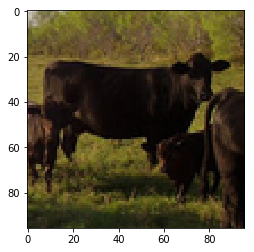

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [7 6 5 4 8]
Revised Top 5: [7 6 5 1 4]
..........................................................................................
Softmax Values:  [0.00000000e+00 9.06815636e-04 1.33182471e-06 2.20613508e-03
 1.06237885e-05 6.92334311e-07 2.19583603e-06 1.28472266e-05
 1.75741025e-06 2.89314357e-03 9.93964434e-01]
Openmax valuess:  [3.80966129e-04 3.14240302e-04 1.99022834e-04 5.55112407e-04
 7.32735136e-05 2.33037934e-06 5.38052858e-06 3.15026506e-05
 4.73325967e-06 3.80126709e-03 9.94632171e-01]


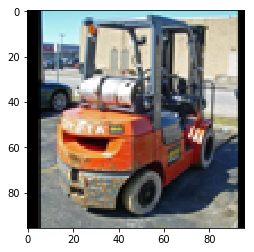

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  9  3  1  7]
Revised Top 5: [10  9  3  0  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 5.8157928e-04 1.1790627e-02 6.9253228e-04 4.4188414e-02
 2.5123235e-02 2.6188669e-01 4.8561830e-02 6.0563296e-01 4.8026763e-04
 1.0618441e-03]
Openmax valuess:  [0.00362977 0.03838777 0.03778015 0.02109187 0.05439221 0.04874067
 0.16704561 0.08155911 0.5409526  0.00261046 0.00380979]


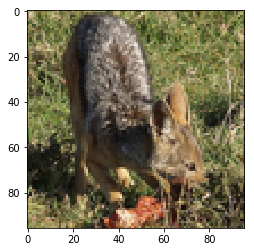

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [8 6 7 4 5]
Revised Top 5: [8 6 7 4 5]
..........................................................................................
Softmax Values:  [0.         0.0013207  0.01061229 0.00066084 0.07338975 0.07757697
 0.59024733 0.22102734 0.02070266 0.00249074 0.00197136]
Openmax valuess:  [0.00888948 0.05758473 0.05445182 0.02955118 0.08697021 0.10202279
 0.32467234 0.25451892 0.06214339 0.0115442  0.00765095]


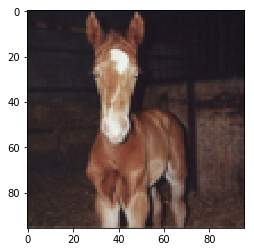

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 7 5 4 8]
Revised Top 5: [6 7 5 4 8]
..........................................................................................
Softmax Values:  [0.00000000e+00 5.40967507e-04 2.31461637e-02 4.19384451e-04
 9.13861454e-01 1.41218714e-02 3.07312440e-02 1.64168223e-03
 3.81043344e-03 1.00816265e-02 1.64513860e-03]
Openmax valuess:  [0.01954264 0.08600768 0.09368243 0.04575154 0.33482691 0.09935418
 0.15194708 0.01980097 0.04425174 0.08764877 0.01718607]


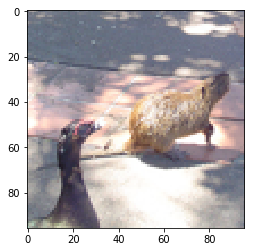

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [4 6 2 5 9]
Revised Top 5: [4 6 5 2 9]
..........................................................................................
Softmax Values:  [0.00000000e+00 1.78481023e-05 7.86334160e-04 1.02437434e-05
 1.01861265e-02 7.88359106e-01 1.09896846e-01 6.39698207e-02
 2.67218687e-02 2.38609755e-05 2.79476481e-05]
Openmax valuess:  [0.00123155 0.02995884 0.02680052 0.0100631  0.0462488  0.3044002
 0.20291095 0.21500845 0.16208201 0.00075013 0.00054545]


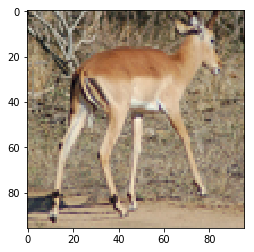

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [5 6 7 8 4]
Revised Top 5: [5 7 6 8 4]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.9687625e-01 1.6226849e-03 2.6253914e-03 9.1450958e-04
 4.4197825e-04 5.1289547e-04 5.9377158e-04 5.5037939e-04 6.0544401e-01
 9.0418100e-02]
Openmax valuess:  [0.02015303 0.01882394 0.01638439 0.01570152 0.01045095 0.00304733
 0.0014859  0.00175992 0.00315606 0.70784703 0.20118994]


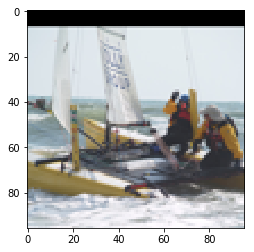

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 9  1 10  3  2]
Revised Top 5: [ 9 10  0  1  2]
..........................................................................................
Softmax Values:  [0.0000000e+00 4.6794798e-05 8.7588094e-03 6.1125822e-05 1.9677594e-02
 9.2139491e-04 9.8264381e-02 1.4351675e-03 8.7076020e-01 1.8013823e-05
 5.6445897e-05]
Openmax valuess:  [1.39417275e-03 1.27294264e-02 1.46127811e-02 6.21459534e-03
 2.45492965e-02 8.98059920e-03 8.49971955e-02 9.22429911e-03
 8.36555213e-01 2.72100803e-04 4.70320389e-04]


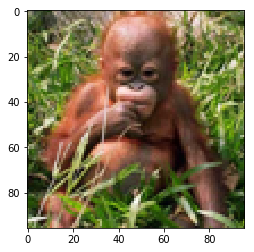

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [8 6 4 2 7]
Revised Top 5: [8 6 4 2 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.6199167e-06 1.4452614e-06 3.3681724e-07 3.7731593e-06
 2.0644113e-03 1.0445041e-03 9.9686611e-01 1.5468417e-05 1.6943885e-07
 2.1480153e-06]
Openmax valuess:  [3.60154308e-05 1.93994715e-03 1.42525952e-03 7.82505829e-04
 1.02595820e-03 1.03310872e-02 1.11632857e-02 9.71915414e-01
 1.17806129e-03 2.96398194e-05 1.72825661e-04]


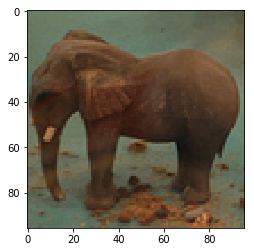

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [7 5 6 8 4]
Revised Top 5: [7 6 5 1 2]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.4173439e-02 4.9884203e-03 2.1052586e-01 1.9205656e-03
 2.7774298e-04 5.2862795e-04 4.5448565e-04 9.8034227e-04 2.0475505e-01
 5.5139542e-01]
Openmax valuess:  [0.04257719 0.01849624 0.01720919 0.03384589 0.01118805 0.00124206
 0.00095305 0.00083215 0.00352552 0.20282268 0.66730797]


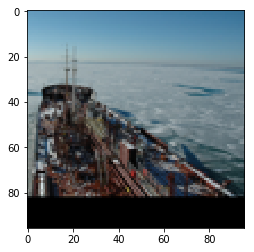

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  9  1  2]
Revised Top 5: [10  9  0  3  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 7.6177280e-04 2.5897846e-04 8.8105875e-01 9.2802464e-04
 3.8726968e-05 2.4508943e-03 9.4534848e-03 7.5884844e-04 2.8859384e-04
 1.0400185e-01]
Openmax valuess:  [0.00260653 0.03327893 0.02560271 0.10017302 0.02222327 0.00166776
 0.0232407  0.08266934 0.01126703 0.0044537  0.692817  ]


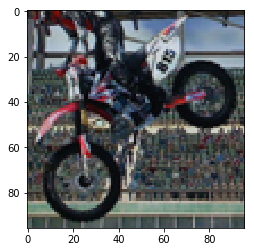

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 3 10  7  6  4]
Revised Top 5: [10  3  7  1  2]
..........................................................................................
Softmax Values:  [0.         0.00317177 0.06811655 0.00690416 0.32484058 0.5144786
 0.01571756 0.01354133 0.03202389 0.01241449 0.00879104]
Openmax valuess:  [0.04287073 0.0896017  0.09617777 0.06531378 0.17705855 0.26705207
 0.06133025 0.04656813 0.08673221 0.04045058 0.02684423]


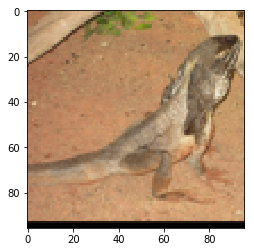

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [5 4 2 8 6]
Revised Top 5: [5 4 2 1 8]
..........................................................................................
Softmax Values:  [0.00000000e+00 8.02173054e-06 1.86542047e-06 9.99710262e-01
 1.48054170e-07 4.21148760e-09 9.33574711e-08 1.06827805e-07
 1.18975301e-07 9.56042982e-07 2.78524152e-04]
Openmax valuess:  [9.87214634e-01 2.96932535e-04 2.62579108e-04 3.24849375e-03
 9.89262522e-06 2.31741040e-07 4.34564232e-06 4.97299456e-06
 5.83606506e-06 6.50485211e-05 8.88703283e-03]


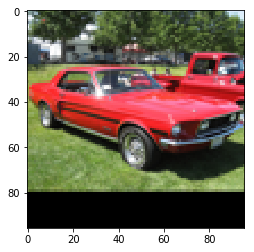

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3 10  1  2  9]
Revised Top 5: [ 0 10  3  1  2]
..........................................................................................
Softmax Values:  [0.         0.0015836  0.05132316 0.00117087 0.36722764 0.03205181
 0.34429958 0.02079912 0.1760771  0.00328968 0.00217742]
Openmax valuess:  [0.01657615 0.0667125  0.07163383 0.03611341 0.14904818 0.07346267
 0.2466457  0.05912053 0.26022952 0.01309082 0.00736668]


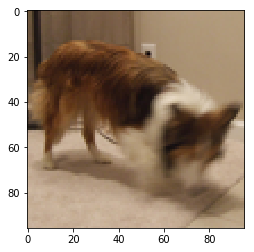

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [4 6 8 2 5]
Revised Top 5: [8 6 4 5 2]
..........................................................................................
Softmax Values:  [0.         0.00133715 0.07538874 0.00135093 0.23848416 0.03363161
 0.18505475 0.01087564 0.45068207 0.00149327 0.00170159]
Openmax valuess:  [0.01965713 0.0544173  0.06159228 0.03118752 0.11146815 0.0646652
 0.15837271 0.03405999 0.45274823 0.00636089 0.0054706 ]


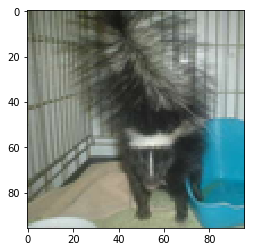

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [8 4 6 2 5]
Revised Top 5: [8 6 4 5 2]
..........................................................................................
Softmax Values:  [0.0000000e+00 5.8986167e-05 3.0351994e-03 1.5494044e-04 1.2294730e-01
 6.6995912e-04 4.9337509e-01 6.7608976e-03 3.7252247e-01 1.4816487e-04
 3.2696492e-04]
Openmax valuess:  [0.00068319 0.02602256 0.02488563 0.01312632 0.06908849 0.01189294
 0.26536198 0.03312548 0.55184465 0.0016255  0.00234326]


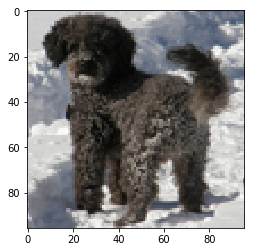

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [6 8 4 7 2]
Revised Top 5: [8 6 4 7 1]
..........................................................................................
Softmax Values:  [0.         0.00073738 0.11894519 0.00261652 0.5311165  0.00621433
 0.08261445 0.00330625 0.24973358 0.0015951  0.0031208 ]
Openmax valuess:  [0.03052311 0.06306344 0.07619238 0.04290628 0.17423374 0.04126028
 0.13530123 0.01606645 0.39829611 0.00909496 0.01306201]


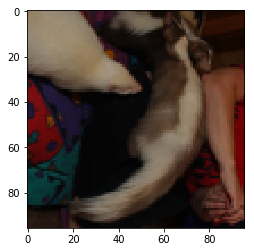

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [4 8 2 6 5]
Revised Top 5: [8 4 6 2 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.8859314e-03 3.5632136e-03 7.3328251e-01 4.4188574e-03
 4.7604684e-04 1.5039197e-03 1.4909673e-03 1.7126447e-03 5.9553850e-03
 2.4471059e-01]
Openmax valuess:  [0.0232878  0.03665369 0.03347912 0.08873936 0.02979389 0.00670807
 0.00664658 0.0065519  0.011641   0.02678077 0.72971781]


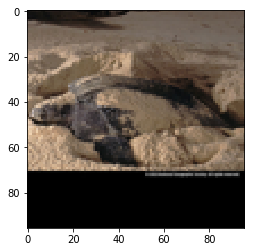

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 3 10  9  4  2]
Revised Top 5: [10  3  1  2  4]
..........................................................................................
Softmax Values:  [0.         0.00079013 0.16989791 0.00126705 0.40586272 0.08684195
 0.10138994 0.01174378 0.21989036 0.0008653  0.00145087]
Openmax valuess:  [0.04401464 0.06305608 0.07766    0.03590782 0.15296626 0.11092396
 0.1380329  0.04223524 0.32466301 0.00488736 0.00565272]


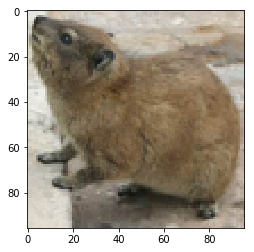

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [4 8 2 6 5]
Revised Top 5: [8 4 6 5 2]
..........................................................................................
Softmax Values:  [0.         0.0012333  0.7009152  0.00440094 0.1280287  0.02180352
 0.01035251 0.00188445 0.12875013 0.0007836  0.00184773]
Openmax valuess:  [0.20034549 0.06605594 0.09709691 0.05176962 0.12597519 0.07695387
 0.0550896  0.01123936 0.29910531 0.00626618 0.01010251]


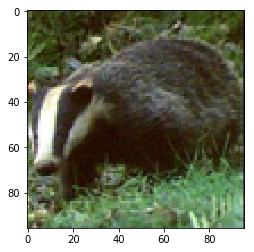

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [2 8 4 5 6]
Revised Top 5: [8 0 4 2 5]
..........................................................................................
Softmax Values:  [0.0000000e+00 6.5526423e-05 1.7853031e-02 1.2411900e-04 8.2678944e-02
 1.0489574e-02 1.0242820e-01 4.9831118e-03 7.8120649e-01 4.5181878e-05
 1.2577229e-04]
Openmax valuess:  [3.20367606e-03 2.12620243e-02 2.42060851e-02 1.02016346e-02
 4.96900381e-02 2.88737204e-02 9.73998149e-02 2.15667583e-02
 7.42304280e-01 5.02072016e-04 7.89895839e-04]


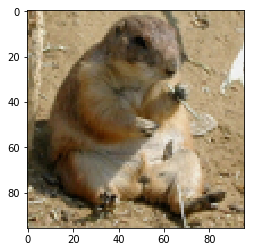

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [8 6 4 2 5]
Revised Top 5: [8 6 4 5 2]
..........................................................................................
Softmax Values:  [0.0000000e+00 9.9941885e-01 2.6752974e-04 1.7944325e-05 2.8212477e-07
 6.0253160e-06 1.2159621e-06 2.8353477e-06 7.8915519e-07 1.4185182e-04
 1.4276881e-04]
Openmax valuess:  [9.97726548e-01 2.69207008e-04 3.20006574e-04 2.21586068e-04
 1.62380443e-05 4.70313602e-05 6.89222937e-06 1.61175087e-05
 5.47291188e-06 6.46006614e-04 7.24893784e-04]


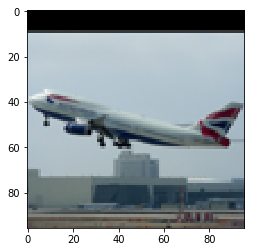

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 1  2 10  9  3]
Revised Top 5: [ 0 10  9  2  1]
..........................................................................................
Softmax Values:  [0.         0.00765595 0.00063041 0.49757    0.00078398 0.00096865
 0.00234558 0.01679054 0.00147252 0.00711494 0.46466747]
Openmax valuess:  [0.00143718 0.02660767 0.02007351 0.05750248 0.01219726 0.00683951
 0.00614892 0.04080465 0.00670239 0.01940796 0.80227847]


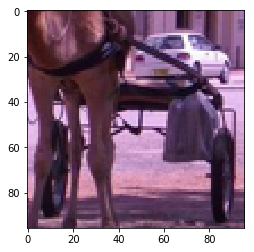

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 3 10  7  1  9]
Revised Top 5: [10  3  7  1  2]
..........................................................................................
Softmax Values:  [0.0000000e+00 4.5580688e-04 9.7489583e-01 8.8013685e-04 1.2101161e-02
 2.7462079e-03 1.1590163e-03 1.5697356e-04 7.2261835e-03 8.9085464e-05
 2.8957491e-04]
Openmax valuess:  [0.69629576 0.03199154 0.05835547 0.02619668 0.05203972 0.03381666
 0.02227577 0.00254592 0.06939456 0.00230189 0.00478603]


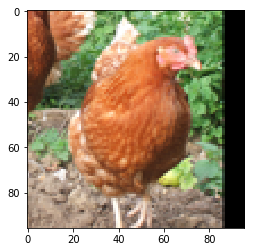

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [2 4 8 5 6]
Revised Top 5: [0 8 2 4 5]
..........................................................................................
Softmax Values:  [0.         0.00169374 0.03782858 0.00253782 0.11443093 0.7570334
 0.03477015 0.03250172 0.01196286 0.00291981 0.00432094]
Openmax valuess:  [0.04826345 0.07653295 0.08143251 0.0504749  0.12850311 0.32521007
 0.10006648 0.10155043 0.05278428 0.01619836 0.01898346]


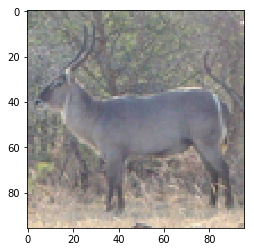

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [5 4 2 6 7]
Revised Top 5: [5 4 7 6 2]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.6736076e-04 2.0965481e-02 3.5244517e-04 2.2769803e-01
 9.6194638e-04 6.0654577e-02 1.1309516e-03 6.8560106e-01 1.7161545e-03
 7.5200776e-04]
Openmax valuess:  [0.00263613 0.02983483 0.03314702 0.01626607 0.08368402 0.01325151
 0.08590279 0.00598724 0.71608782 0.00935259 0.00384997]


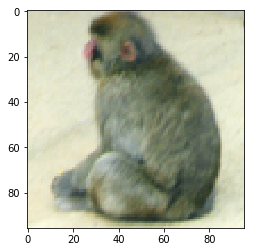

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [8 4 6 2 9]
Revised Top 5: [8 6 4 2 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 4.9400908e-01 5.1047641e-04 2.2794884e-03 6.5557753e-05
 2.9525696e-04 2.5315082e-04 6.8507288e-03 7.1691582e-05 4.4987337e-03
 4.9116582e-01]
Openmax valuess:  [6.85381950e-03 9.69129495e-03 8.09256932e-03 9.11514074e-03
 3.04852788e-03 1.89376808e-03 7.92263268e-04 2.08922464e-02
 4.70958491e-04 1.30650299e-02 9.26084381e-01]


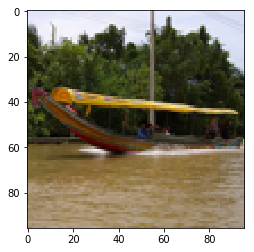

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 1 10  7  9  3]
Revised Top 5: [10  7  9  1  3]
..........................................................................................
Softmax Values:  [0.         0.01121611 0.5742155  0.02874482 0.20955987 0.1063748
 0.01093336 0.00355855 0.01426989 0.02677138 0.01435574]
Openmax valuess:  [0.28144769 0.08330036 0.10877876 0.07804377 0.13709086 0.12340743
 0.04364881 0.00978043 0.04061341 0.06063192 0.03325657]


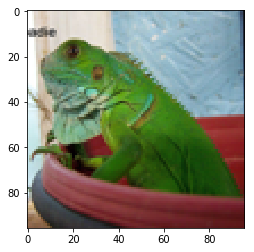

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [2 4 5 3 9]
Revised Top 5: [0 4 5 2 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.6105522e-04 1.0523378e-03 7.9386425e-04 5.3951693e-01
 4.5510223e-03 3.4794857e-04 7.9867728e-05 3.4368911e-04 4.0521306e-01
 4.7840297e-02]
Openmax valuess:  [1.35653371e-03 2.14228684e-02 1.82007284e-02 1.46156498e-02
 8.54016039e-02 1.99235439e-02 1.53053793e-03 3.29455658e-04
 3.12725330e-03 6.80752772e-01 1.53339053e-01]


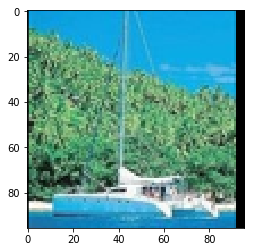

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 4  9 10  5  2]
Revised Top 5: [ 9 10  4  1  5]
..........................................................................................
Softmax Values:  [0.0000000e+00 4.2676533e-08 3.7033736e-08 7.6837940e-09 2.4272157e-07
 7.7291561e-04 5.2182353e-04 9.9870455e-01 3.9361802e-07 2.8196103e-09
 6.4055186e-08]
Openmax valuess:  [2.85598778e-06 4.02240843e-04 1.27158123e-04 1.27897476e-04
 9.07799566e-05 4.07624543e-03 4.02257260e-02 9.54839484e-01
 9.01345991e-05 1.84365674e-06 1.56335636e-05]


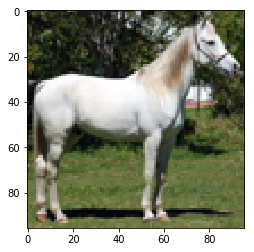

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [7 5 6 8 4]
Revised Top 5: [7 6 5 1 3]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.0600225e-03 1.7629812e-06 3.0765585e-03 4.8055658e-06
 4.0904399e-07 2.6523719e-06 1.9150615e-05 8.7350139e-07 2.5839752e-03
 9.9324977e-01]
Openmax valuess:  [1.13466404e-03 2.81103847e-04 1.85388155e-04 5.44077371e-04
 2.98241004e-05 1.35233681e-06 6.58272062e-06 4.75509704e-05
 2.31472314e-06 3.43100085e-03 9.94336141e-01]


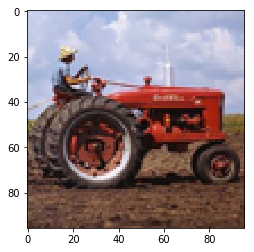

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  9  1  7]
Revised Top 5: [10  9  0  3  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.5866679e-05 9.3016359e-09 7.4902215e-05 6.9169758e-08
 5.5675264e-09 1.3035204e-08 2.3877493e-07 1.7255447e-08 4.3394780e-04
 9.9947494e-01]
Openmax valuess:  [2.01992280e-03 1.14590015e-05 9.63316755e-08 2.14686418e-05
 2.49769682e-07 2.10931241e-08 4.60319020e-08 8.43205634e-07
 6.09819838e-08 5.75615164e-04 9.97370217e-01]


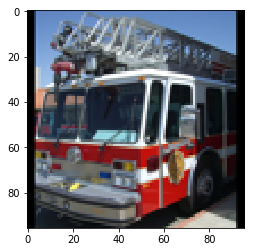

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  9  3  1  7]
Revised Top 5: [10  0  9  3  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 6.0443550e-02 2.2148124e-03 5.9382492e-01 1.6960034e-03
 4.2215487e-04 4.7984486e-04 5.0390197e-04 4.9646822e-04 1.6028897e-01
 1.7962931e-01]
Openmax valuess:  [0.10961598 0.03563324 0.03022345 0.0784327  0.02007005 0.00296009
 0.00148775 0.00158643 0.00356938 0.29337211 0.42304881]


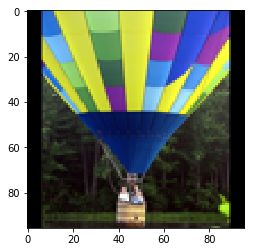

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3 10  9  1  2]
Revised Top 5: [10  9  0  3  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 5.6127163e-05 2.9405876e-07 3.0455081e-04 5.1283752e-07
 6.4692195e-08 8.5181007e-08 7.7796210e-07 7.8899028e-08 2.9100140e-03
 9.9672753e-01]
Openmax valuess:  [8.34234397e-04 4.63388506e-05 1.22040390e-05 8.42736842e-05
 1.90917987e-06 2.22434522e-07 2.57846896e-07 2.35503153e-06
 2.40376499e-07 3.08404304e-03 9.95933921e-01]


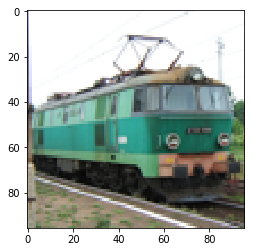

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  9  3  1  7]
Revised Top 5: [10  9  0  3  1]
..........................................................................................
Softmax Values:  [0.00000000e+00 2.00223105e-04 6.39730766e-02 7.19505129e-04
 3.74119319e-02 1.31513095e-02 1.44546805e-02 1.10803079e-03
 8.68488789e-01 1.02147962e-04 3.90421774e-04]
Openmax valuess:  [0.01258392 0.02427502 0.03077919 0.01590604 0.04212659 0.0333226
 0.03781407 0.00623862 0.79392586 0.0009387  0.0020894 ]


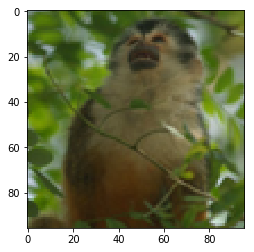

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [8 2 4 6 5]
Revised Top 5: [8 4 6 5 2]
..........................................................................................
Softmax Values:  [0.         0.24653782 0.66775936 0.0040285  0.01563462 0.01204049
 0.0105182  0.00227284 0.0079849  0.02892095 0.00430229]
Openmax valuess:  [0.61902595 0.05063638 0.07111747 0.03594137 0.04548245 0.03953002
 0.0337128  0.00623018 0.02462708 0.06220796 0.01148835]


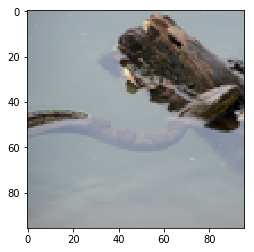

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [2 1 9 4 5]
Revised Top 5: [0 2 9 1 4]
..........................................................................................
Softmax Values:  [0.0000000e+00 6.3644999e-05 2.2083565e-03 8.7518347e-05 4.8670728e-02
 3.8568077e-03 8.3844727e-01 3.5583448e-02 7.0857644e-02 9.8471828e-05
 1.2618444e-04]
Openmax valuess:  [0.00152228 0.03312527 0.03099033 0.01520193 0.06859922 0.03171683
 0.46259003 0.11772454 0.23553132 0.00161468 0.00138358]


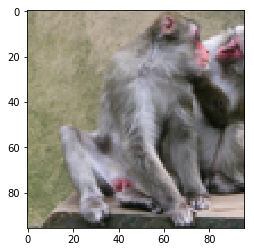

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 8 4 7 5]
Revised Top 5: [6 8 7 4 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 7.3608186e-05 4.3416350e-08 3.1703600e-04 2.0655563e-07
 1.5355676e-08 4.8943974e-08 5.8910342e-07 2.4162626e-08 6.8308011e-04
 9.9892539e-01]
Openmax valuess:  [5.11655770e-03 2.66732261e-05 7.97391670e-07 5.52366035e-05
 6.94847097e-07 5.38076458e-08 1.56827875e-07 1.88765702e-06
 7.75545312e-08 9.06508000e-04 9.93891356e-01]


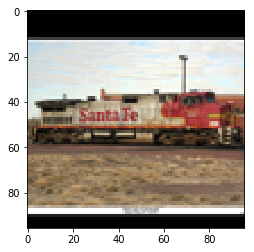

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  9  3  1  7]
Revised Top 5: [10  0  9  3  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 3.4542227e-05 2.1741688e-04 6.6564503e-06 1.1440457e-03
 5.0208652e-01 4.1176483e-02 4.5442757e-01 8.6556200e-04 1.7381413e-05
 2.3838842e-05]
Openmax valuess:  [1.22994384e-03 1.74029584e-02 1.47228250e-02 6.20224768e-03
 1.73409272e-02 1.97464696e-01 1.03786634e-01 6.26519136e-01
 1.41972098e-02 6.05063662e-04 5.28358132e-04]


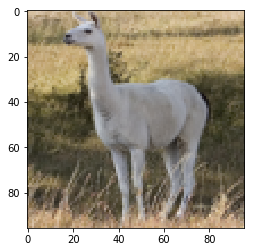

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [5 7 6 4 8]
Revised Top 5: [7 5 6 1 4]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.6129515e-04 2.2889715e-02 6.0720003e-04 6.6595620e-01
 2.6291427e-01 2.3573758e-02 4.2279549e-03 1.7535191e-02 1.0510100e-03
 9.8335335e-04]
Openmax valuess:  [0.02472019 0.0736245  0.07922355 0.04125006 0.25215052 0.26207148
 0.1077895  0.03748187 0.10205523 0.01125256 0.00838055]


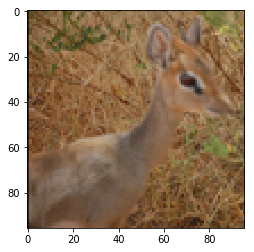

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [4 5 6 2 8]
Revised Top 5: [5 4 6 8 2]
..........................................................................................
Softmax Values:  [0.0000000e+00 5.0035963e-04 2.0491611e-06 2.6535245e-03 5.4594066e-06
 1.0804325e-06 9.4238442e-07 3.6322474e-06 8.8371377e-07 7.0902981e-02
 9.2592913e-01]
Openmax valuess:  [1.52131100e-03 3.15281863e-04 1.94934294e-04 5.79445972e-04
 2.37196925e-05 3.20197231e-06 2.34786864e-06 9.05049509e-06
 2.24299386e-06 4.98227799e-02 9.47525684e-01]


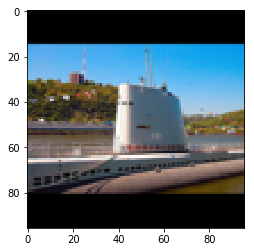

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  9  3  1  4]
Revised Top 5: [10  9  0  3  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 8.8326391e-07 1.9673882e-06 1.7400551e-07 4.4331431e-05
 3.5018090e-02 1.1164885e-02 9.5371908e-01 4.9073526e-05 2.7824703e-07
 1.2200938e-06]
Openmax valuess:  [2.92423595e-05 3.16695128e-03 2.19825114e-03 9.39394077e-04
 2.69647042e-03 3.68592111e-02 3.84417454e-02 9.13219501e-01
 2.33648442e-03 3.56912001e-05 7.70579672e-05]


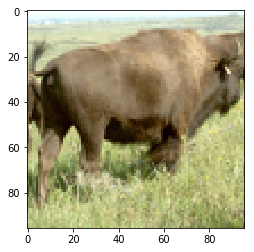

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [7 5 6 8 4]
Revised Top 5: [7 6 5 1 4]
..........................................................................................
Softmax Values:  [0.         0.00528579 0.00733359 0.32425982 0.00711806 0.00069832
 0.051464   0.25732425 0.15222839 0.00105122 0.19323651]
Openmax valuess:  [0.00170401 0.05299914 0.04601274 0.085232   0.03437242 0.01084136
 0.06924824 0.24919596 0.16464901 0.00361613 0.28212899]


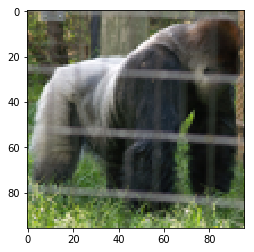

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3  7 10  8  6]
Revised Top 5: [10  7  8  3  6]
..........................................................................................
Softmax Values:  [0.00000000e+00 3.57948352e-06 1.12019961e-06 9.99876440e-01
 1.49666775e-07 1.89002414e-09 5.83740132e-08 2.63337459e-08
 9.23346164e-08 1.29494299e-06 1.17207994e-04]
Openmax valuess:  [9.89678646e-01 3.09416730e-04 2.69926572e-04 3.64819187e-03
 1.38375697e-05 1.53472384e-07 4.11610459e-06 1.85691831e-06
 6.76647463e-06 1.16552815e-04 5.95053558e-03]


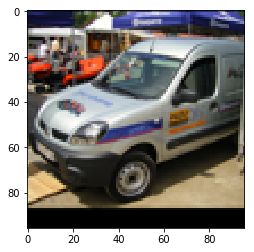

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3 10  1  9  2]
Revised Top 5: [ 0 10  3  1  2]
..........................................................................................
Softmax Values:  [0.0000000e+00 9.6311343e-01 1.3590443e-03 1.3876422e-03 6.8076224e-05
 2.2862920e-04 1.1587099e-04 4.8884394e-04 8.0858903e-05 6.7365617e-03
 2.6421050e-02]
Openmax valuess:  [0.36944176 0.03661294 0.03536447 0.03430115 0.01343882 0.00877749
 0.00220684 0.00951392 0.00336848 0.09982962 0.38714452]


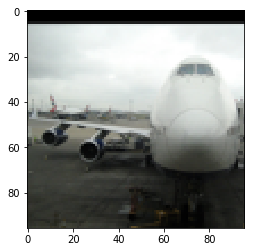

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 1 10  9  3  2]
Revised Top 5: [10  0  9  1  2]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.3609398e-02 6.0602719e-07 2.0581519e-04 6.8388658e-08
 2.6220453e-08 7.0924393e-08 2.4169540e-06 5.4562243e-08 1.6976801e-04
 9.7601181e-01]
Openmax valuess:  [2.63970612e-01 4.46775411e-05 7.00329195e-06 7.11070417e-05
 1.53772541e-07 6.29390372e-08 1.57225941e-07 5.35800030e-06
 1.21053013e-07 2.45745380e-04 7.35655001e-01]


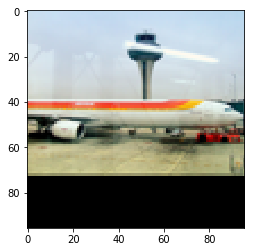

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  1  3  9  7]
Revised Top 5: [10  0  9  3  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 3.7423908e-06 1.8956900e-05 7.5211119e-07 1.5995097e-04
 3.7949353e-03 6.9249682e-02 9.2657977e-01 1.8730707e-04 9.1143903e-07
 3.9077318e-06]
Openmax valuess:  [1.17170808e-04 5.23197956e-03 4.16000477e-03 1.73470074e-03
 4.98672350e-03 1.74161446e-02 1.00491712e-01 8.60403314e-01
 5.22409874e-03 7.37321020e-05 1.60419768e-04]


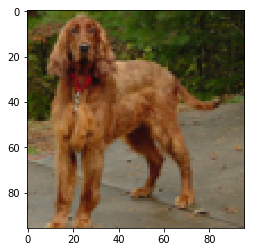

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [7 6 5 8 4]
Revised Top 5: [7 6 5 1 8]
..........................................................................................
Softmax Values:  [0.0000000e+00 9.9897772e-01 9.9291117e-04 6.6771172e-08 8.4718428e-09
 2.8601769e-07 7.0448557e-08 2.1881741e-08 6.4593863e-08 2.7282738e-05
 1.4628655e-06]
Openmax valuess:  [9.99995140e-01 5.37406386e-07 9.46536419e-07 2.44066153e-07
 1.68118161e-09 5.13294086e-08 1.09549291e-08 3.40293924e-09
 1.01979289e-08 2.80647320e-06 2.47900819e-07]


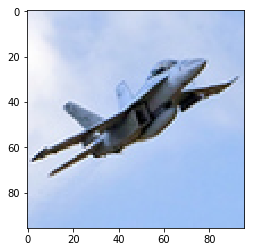

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 1  2  9 10  5]
Revised Top 5: [ 0  9  2  1 10]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.6866288e-07 2.4538499e-04 1.0815685e-06 6.0395064e-04
 2.6413788e-06 2.5962866e-03 1.5024805e-05 9.9653488e-01 4.9990248e-08
 5.3363345e-07]
Openmax valuess:  [2.92782436e-05 8.70263387e-04 1.03574698e-03 4.16579453e-04
 1.92223126e-03 2.52349366e-04 6.75955068e-03 3.16429835e-04
 9.88376926e-01 3.90574833e-06 1.67391327e-05]


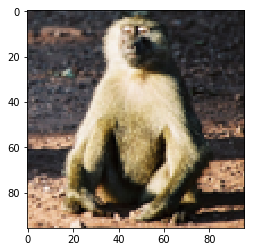

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [8 6 4 2 7]
Revised Top 5: [8 6 4 2 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.8109929e-05 4.9238056e-03 7.7972909e-05 1.8462320e-01
 4.4236523e-03 5.0808676e-02 1.5408726e-03 7.5341916e-01 4.2703803e-05
 1.2188863e-04]
Openmax valuess:  [1.00947477e-03 1.69146080e-02 1.77388602e-02 8.11928992e-03
 5.78693841e-02 1.96023915e-02 6.89285726e-02 9.92729263e-03
 7.98405262e-01 5.54759372e-04 9.30104970e-04]


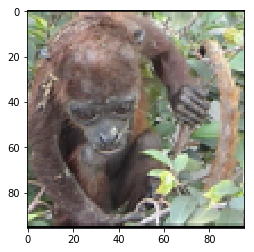

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [8 4 6 2 5]
Revised Top 5: [8 6 4 5 2]
..........................................................................................
Softmax Values:  [0.         0.00285263 0.02618324 0.00087262 0.07957833 0.7177529
 0.10735811 0.04619727 0.0155935  0.00220845 0.00140305]
Openmax valuess:  [0.05041925 0.06925202 0.07164174 0.03753705 0.10702    0.29822759
 0.1661524  0.11934117 0.06109594 0.01256475 0.00674809]


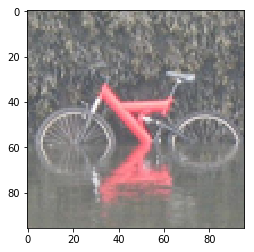

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [5 6 4 7 2]
Revised Top 5: [5 6 7 4 2]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.1078343e-02 9.7686518e-04 2.5841683e-01 3.7050769e-03
 3.3649188e-04 2.3102281e-03 6.9742934e-03 1.9787657e-03 7.3909648e-03
 7.0683217e-01]
Openmax valuess:  [0.00276433 0.02014928 0.01584357 0.03801403 0.01461265 0.00250697
 0.00457154 0.01330476 0.00613771 0.01486283 0.86723233]


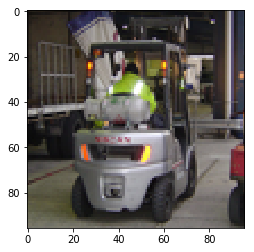

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  1  9  7]
Revised Top 5: [10  3  1  2  9]
..........................................................................................
Softmax Values:  [0.0000000e+00 5.4164656e-04 4.5805606e-03 1.5428398e-03 1.4673300e-01
 5.0548115e-03 7.5679427e-01 4.1296706e-02 3.9849844e-02 1.3254728e-03
 2.2808216e-03]
Openmax valuess:  [0.0034541  0.05856367 0.05243914 0.03777142 0.11895778 0.03916083
 0.43330557 0.11292498 0.12287819 0.00897446 0.01156989]


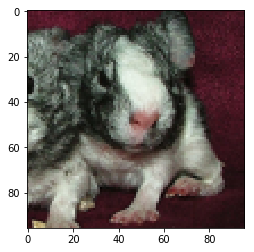

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 4 7 8 5]
Revised Top 5: [6 8 4 7 1]
..........................................................................................
Softmax Values:  [0.         0.00222401 0.00666073 0.00381244 0.07920548 0.49819443
 0.15009822 0.23773794 0.01082752 0.00371964 0.00751973]
Openmax valuess:  [0.01054    0.06950722 0.06043352 0.04699614 0.09601606 0.22313753
 0.16394441 0.25648605 0.03668349 0.01424284 0.02201273]


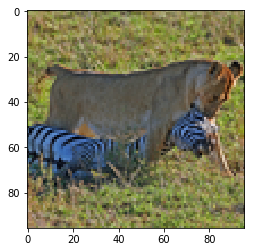

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [5 7 6 4 8]
Revised Top 5: [7 5 6 4 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 9.9819285e-01 9.6800469e-04 1.1711944e-05 1.1664392e-06
 9.7336133e-06 3.6548195e-06 2.8860231e-06 2.7537030e-06 6.0265674e-04
 2.0459738e-04]
Openmax valuess:  [9.87755711e-01 1.22950359e-03 1.55575067e-03 8.14142631e-04
 2.55254126e-04 1.96865164e-04 4.88450131e-05 3.87269357e-05
 5.03826113e-05 5.53051323e-03 2.52430550e-03]


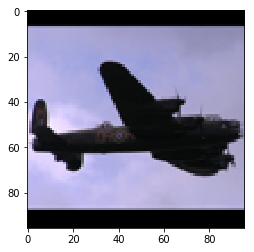

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 1  2  9 10  3]
Revised Top 5: [ 0  9 10  2  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 6.0642007e-05 3.7448725e-04 3.0141675e-05 4.1403202e-03
 3.2278392e-01 1.1897848e-01 5.4591709e-01 7.5871348e-03 5.1526360e-05
 7.6218574e-05]
Openmax valuess:  [0.00087527 0.02431095 0.0197719  0.00971496 0.02689182 0.15884647
 0.1541877  0.55653731 0.0470084  0.00095202 0.00090319]


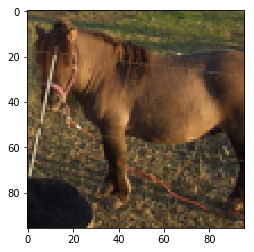

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [7 5 6 8 4]
Revised Top 5: [7 5 6 8 4]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.7342089e-07 2.3956288e-06 6.2099069e-08 5.3073512e-04
 1.5284403e-01 1.4250150e-01 7.0400375e-01 1.1668413e-04 2.1155536e-07
 4.2650325e-07]
Openmax valuess:  [4.27946078e-05 1.38639798e-03 2.85128337e-03 9.27276038e-04
 6.56960206e-03 7.33261385e-02 1.46780908e-01 7.63962098e-01
 4.10127413e-03 2.61717931e-05 2.60560188e-05]


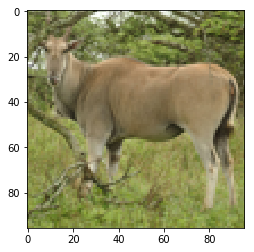

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [7 5 6 4 8]
Revised Top 5: [7 6 5 4 8]
..........................................................................................
Softmax Values:  [0.0000000e+00 6.7713854e-06 1.7873138e-03 4.3676260e-05 9.9370944e-01
 7.4613595e-04 2.6252333e-03 8.1201317e-05 2.7319838e-04 4.1595745e-04
 3.1104640e-04]
Openmax valuess:  [0.00706111 0.06693836 0.07159399 0.03644912 0.54550305 0.06176294
 0.11354452 0.00724694 0.02877927 0.03570801 0.02541269]


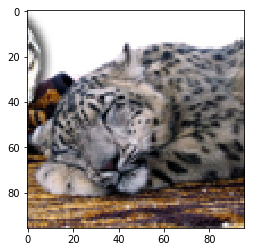

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [4 6 2 5 9]
Revised Top 5: [4 6 2 1 5]
..........................................................................................
Softmax Values:  [0.         0.03763599 0.01827367 0.00699927 0.02274933 0.00733219
 0.00395999 0.0021226  0.00987705 0.84833467 0.04271519]
Openmax valuess:  [0.01222857 0.03785472 0.03722104 0.03020663 0.03842981 0.02455596
 0.01100451 0.00418319 0.02186552 0.71262413 0.06982593]


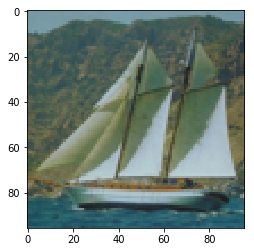

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 9 10  1  4  2]
Revised Top 5: [ 9 10  4  1  2]
..........................................................................................
Softmax Values:  [0.0000000e+00 9.6031482e-04 4.1386975e-06 5.5850710e-04 3.0323446e-05
 2.4359015e-06 2.0688178e-06 1.4154903e-06 1.8596495e-06 9.6799648e-01
 3.0442502e-02]
Openmax valuess:  [1.48166430e-03 8.49943294e-04 5.89652584e-04 1.09102692e-03
 3.86712011e-04 1.68984118e-05 1.09726390e-05 7.50954519e-06
 1.05016607e-05 9.00011590e-01 9.55435287e-02]


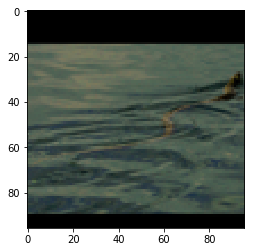

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 9 10  1  3  4]
Revised Top 5: [ 9 10  0  3  1]
..........................................................................................
Softmax Values:  [0.         0.00960908 0.01458178 0.06440898 0.21149926 0.00809656
 0.3419831  0.0529215  0.18260373 0.02010108 0.09419498]
Openmax valuess:  [0.00546768 0.08426201 0.0726614  0.08433404 0.12053055 0.03682269
 0.1945757  0.0736722  0.17527695 0.03330691 0.11908986]


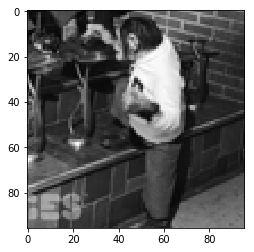

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 6  4  8 10  3]
Revised Top 5: [ 6  8  4 10  3]
..........................................................................................
Softmax Values:  [0.0000000e+00 3.3292067e-04 6.9523836e-03 5.6047685e-04 1.3793781e-01
 4.9083508e-03 4.5137706e-01 1.9903855e-02 3.7655771e-01 5.6771858e-04
 9.0166688e-04]
Openmax valuess:  [0.00233859 0.0400236  0.03813268 0.02195651 0.08482516 0.02869206
 0.25317753 0.05665692 0.46641577 0.0036624  0.00411878]


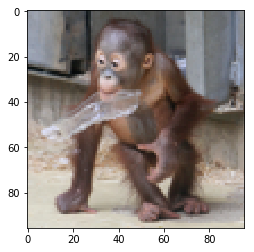

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 8 4 7 2]
Revised Top 5: [8 6 4 7 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 7.8063799e-08 1.6592827e-05 6.4860600e-08 5.5270181e-03
 5.1536645e-05 9.9276400e-01 8.3716080e-04 8.0302911e-04 2.9947449e-07
 1.8215943e-07]
Openmax valuess:  [2.82302746e-05 6.71588255e-03 5.90776171e-03 1.71456897e-03
 2.61116231e-02 6.32791887e-03 8.65297178e-01 4.63909961e-02
 4.13723172e-02 9.70093714e-05 3.65140582e-05]


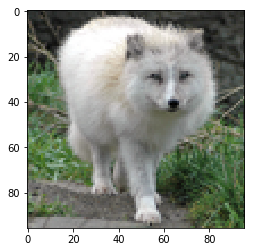

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [6 4 7 8 5]
Revised Top 5: [6 7 8 4 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.6944922e-04 1.2978983e-02 1.7335569e-02 9.2196029e-01
 2.8957145e-03 4.3721278e-03 5.6991290e-04 6.3472189e-04 1.1868373e-02
 2.7214952e-02]
Openmax valuess:  [0.01226917 0.07920213 0.081835   0.08959439 0.31389546 0.04953953
 0.05334388 0.00550002 0.01204183 0.09578008 0.20699852]


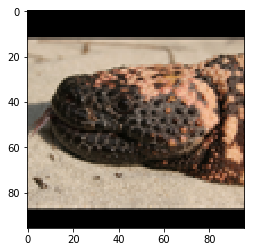

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 4 10  3  2  9]
Revised Top 5: [ 4 10  9  3  2]
..........................................................................................
Softmax Values:  [0.0000000e+00 6.2832201e-04 4.7308039e-02 4.6737767e-03 4.4680923e-02
 3.7595415e-03 2.6320137e-02 1.4693708e-03 8.6791009e-01 4.7395984e-04
 2.7759352e-03]
Openmax valuess:  [0.01161734 0.03385788 0.03931868 0.02873986 0.05212346 0.02236126
 0.05333741 0.00658001 0.73911389 0.0028172  0.01013301]


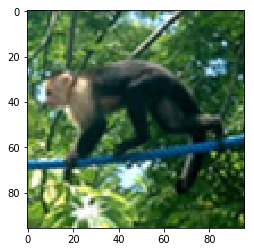

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [8 2 4 6 3]
Revised Top 5: [8 6 4 2 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 4.2080661e-04 9.5041609e-01 5.6959939e-04 1.0343859e-02
 1.9463782e-03 6.7002052e-03 2.7640371e-04 2.9142581e-02 6.4492568e-05
 1.1951493e-04]
Openmax valuess:  [0.43969323 0.04501822 0.08012082 0.03233208 0.06538681 0.03796138
 0.06749332 0.00532351 0.22208422 0.00209663 0.00248977]


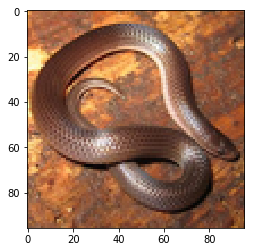

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [2 8 4 6 5]
Revised Top 5: [0 8 2 6 4]
..........................................................................................
Softmax Values:  [0.0000000e+00 5.4368126e-04 8.6520873e-03 8.0320903e-04 1.4870459e-01
 7.5285369e-01 6.1486356e-02 1.6715499e-02 7.3534343e-03 1.3624590e-03
 1.5249492e-03]
Openmax valuess:  [0.01865799 0.06872483 0.06632189 0.03978704 0.14497877 0.35573163
 0.15334117 0.08240963 0.04780517 0.01178207 0.01045981]


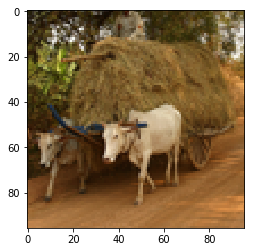

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [5 4 6 7 2]
Revised Top 5: [5 6 4 7 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 8.4219819e-06 2.8427882e-04 2.0100940e-06 3.2187251e-03
 9.8269451e-01 7.6346393e-03 5.8273273e-03 3.1293655e-04 1.0794981e-05
 6.3444522e-06]
Openmax valuess:  [5.29182814e-03 2.83493191e-02 2.70239808e-02 9.56864365e-03
 5.08562704e-02 6.09310972e-01 1.15637339e-01 1.30261986e-01
 2.16864116e-02 1.41181585e-03 6.01433329e-04]


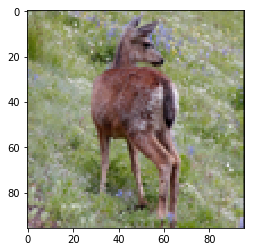

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [5 6 7 4 8]
Revised Top 5: [5 7 6 4 1]
..........................................................................................
Softmax Values:  [0.         0.0435143  0.51076466 0.01006343 0.01522381 0.00290063
 0.01752684 0.00229785 0.16294135 0.21580526 0.01896195]
Openmax valuess:  [0.0715056  0.07143054 0.09365397 0.05598523 0.0561179  0.02667852
 0.04992585 0.00556983 0.21381936 0.31310855 0.04220464]


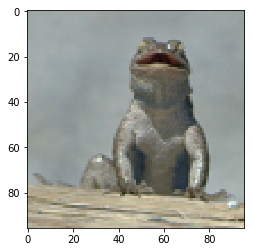

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 2  9  8  1 10]
Revised Top 5: [9 8 2 0 1]
..........................................................................................
Softmax Values:  [0.0000000e+00 8.7417061e-07 2.5260150e-07 4.0659671e-08 3.6595804e-07
 1.9370152e-04 2.1426525e-04 9.9958861e-01 7.9515655e-07 1.7973681e-08
 1.1119313e-06]
Openmax valuess:  [9.04791796e-06 7.35798457e-04 5.35016294e-04 2.69973246e-04
 2.93099626e-04 2.93136743e-03 6.70520680e-03 9.88186500e-01
 1.68374514e-04 6.94040606e-06 1.58675531e-04]


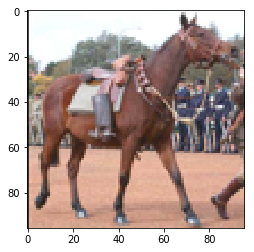

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 7  6  5 10  1]
Revised Top 5: [7 6 5 1 2]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.9313284e-04 3.5722691e-03 2.1445098e-04 2.1041395e-02
 8.9035491e-03 4.6542624e-01 5.4592822e-02 4.4533023e-01 2.2555282e-04
 5.0038518e-04]
Openmax valuess:  [0.00103532 0.03015297 0.02792739 0.01473694 0.04078214 0.03197266
 0.23457663 0.09773419 0.51671199 0.00179133 0.00257844]


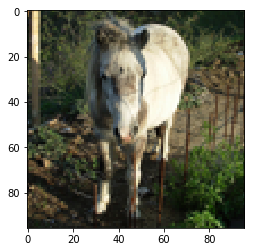

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [6 8 7 4 5]
Revised Top 5: [8 6 7 4 5]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.1136735e-02 1.1252416e-03 2.4614911e-01 2.4573016e-03
 6.0302432e-04 1.7983505e-03 6.9522588e-03 1.7827977e-03 1.7167453e-02
 7.0082778e-01]
Openmax valuess:  [0.00404457 0.02225856 0.01752536 0.04053473 0.01373316 0.00361848
 0.0033709  0.01293068 0.00576216 0.02908199 0.84713942]


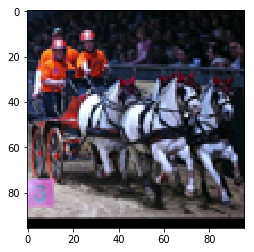

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  1  9  7]
Revised Top 5: [10  3  9  1  2]
..........................................................................................
Softmax Values:  [0.         0.00330911 0.3130154  0.00176832 0.05792293 0.0348686
 0.42136994 0.08287805 0.08256636 0.00088266 0.00141863]
Openmax valuess:  [0.08886957 0.06496575 0.08379504 0.03838407 0.08403717 0.07474245
 0.26909312 0.13477576 0.15180551 0.00454086 0.00499071]


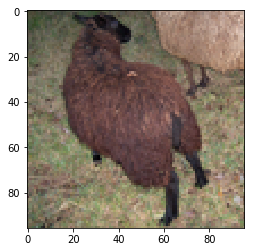

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [6 2 7 8 4]
Revised Top 5: [6 8 7 0 4]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.1095259e-06 4.1082318e-04 3.8268587e-07 3.0436070e-04
 9.9828452e-01 3.9587903e-04 5.2695471e-04 7.3658499e-05 7.3855858e-07
 6.8172290e-07]
Openmax valuess:  [1.90044382e-02 1.83344842e-02 2.15348592e-02 6.26401623e-03
 2.71524367e-02 7.88863424e-01 4.02336276e-02 6.09667563e-02
 1.69777304e-02 4.22706993e-04 2.45519736e-04]


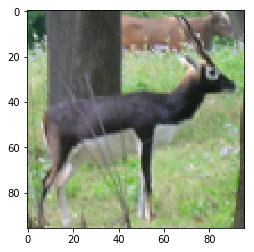

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [5 7 2 6 4]
Revised Top 5: [5 7 6 4 2]
..........................................................................................
Softmax Values:  [0.00000000e+00 1.08619795e-04 5.76039440e-07 1.39552273e-03
 2.52014274e-06 2.73793091e-07 1.12728742e-06 6.50200673e-06
 5.09127119e-07 2.29562982e-03 9.96188760e-01]
Openmax valuess:  [1.26852599e-04 1.39831068e-04 8.91064903e-05 2.69818634e-04
 1.56787555e-05 9.44679494e-07 3.02164016e-06 1.74348646e-05
 1.43805826e-06 2.88674662e-03 9.96449127e-01]


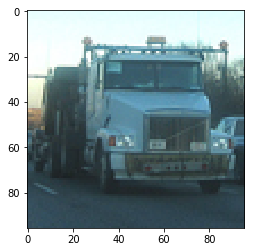

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  9  3  1  7]
Revised Top 5: [10  9  3  1  0]
..........................................................................................
Softmax Values:  [0.0000000e+00 9.9950963e-01 4.8934317e-07 1.2993713e-07 1.4745553e-10
 2.7915286e-09 1.3087850e-09 3.9425682e-08 5.8344107e-10 4.7363187e-06
 4.8490905e-04]
Openmax valuess:  [9.99709212e-01 6.47489491e-07 5.94167249e-07 4.83574649e-07
 1.70750979e-10 3.34709249e-09 1.51538052e-09 4.56491969e-08
 6.75550254e-10 3.57702536e-06 2.85433955e-04]


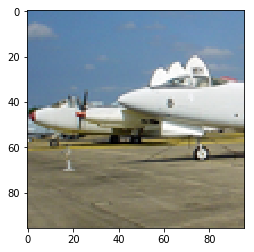

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 1 10  9  2  3]
Revised Top 5: [ 0 10  9  1  2]
..........................................................................................
Softmax Values:  [0.0000000e+00 9.7657794e-06 2.1878155e-05 9.9934787e-01 1.9731217e-06
 4.7820809e-08 1.9365424e-07 8.4000682e-08 3.1167772e-07 2.6936281e-05
 5.9085962e-04]
Openmax valuess:  [9.68876295e-01 1.00476616e-03 1.00267248e-03 8.55449534e-03
 2.10648909e-04 2.69769488e-06 8.71008335e-06 3.77850576e-06
 1.58548372e-05 1.16702274e-03 1.91530585e-02]


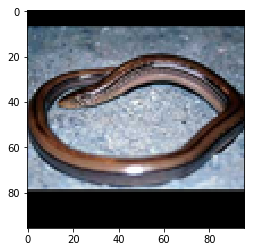

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [ 3 10  9  2  1]
Revised Top 5: [ 0 10  3  9  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 1.5699567e-02 1.6594488e-04 1.7117199e-03 4.1493156e-04
 1.3660696e-04 1.2281328e-04 1.7024550e-04 1.0179430e-04 8.3866185e-01
 1.4281453e-01]
Openmax valuess:  [1.54231779e-03 6.09988061e-03 4.71457425e-03 5.81108718e-03
 3.70756311e-03 7.51792766e-04 3.43416367e-04 4.81243036e-04
 5.16003111e-04 7.13163166e-01 2.62868955e-01]


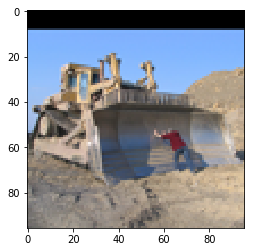

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 9 10  1  3  4]
Revised Top 5: [ 9 10  1  3  2]
..........................................................................................
Softmax Values:  [0.         0.00565872 0.01343267 0.2167688  0.11723077 0.02379102
 0.00376884 0.00452368 0.00217363 0.1366681  0.4759838 ]
Openmax valuess:  [0.0130274  0.05025124 0.04569842 0.07248072 0.0723892  0.0431981
 0.00790964 0.00726327 0.00722345 0.15037856 0.53017999]


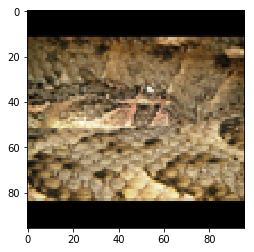

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  9  4  5]
Revised Top 5: [10  9  3  4  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 4.4614542e-03 8.2887156e-05 1.5612660e-01 6.2201070e-05
 1.8106768e-05 3.9419418e-05 2.5795720e-04 3.5966827e-05 8.8549702e-04
 8.3802992e-01]
Openmax valuess:  [3.96089593e-03 2.53453769e-03 1.95405083e-03 6.80723741e-03
 1.06562216e-03 7.51235363e-05 8.94319721e-05 5.88442108e-04
 1.39172171e-04 2.10453179e-03 9.80680954e-01]


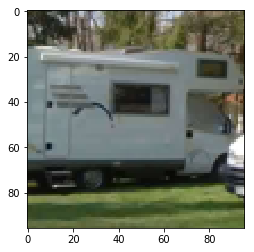

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [10  3  1  9  7]
Revised Top 5: [10  3  0  1  9]
..........................................................................................
Softmax Values:  [0.0000000e+00 2.3607309e-01 7.5677115e-01 3.8920625e-05 3.0915171e-04
 4.2815572e-03 1.3237708e-03 1.4165546e-04 5.2657304e-04 4.2852547e-04
 1.0560998e-04]
Openmax valuess:  [9.69518274e-01 4.39223986e-03 8.02665446e-03 2.03528924e-03
 2.57984573e-03 6.18208547e-03 3.32729557e-03 3.77429769e-04
 1.84234747e-03 1.38001522e-03 3.38523701e-04]


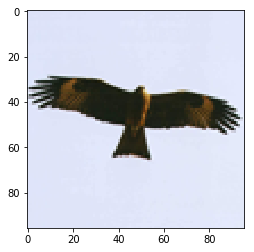

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Unknown

Unrevised Values:  [2 1 5 6 8]
Revised Top 5: [0 2 5 1 6]
..........................................................................................
Softmax Values:  [0.0000000e+00 7.2166574e-01 4.7603706e-04 5.8856264e-02 8.7675711e-05
 8.3028994e-05 7.5477510e-05 2.9421208e-04 6.5181172e-05 2.4565451e-02
 1.9383091e-01]
Openmax valuess:  [3.03322240e-01 1.56127120e-02 1.27454266e-02 2.72684706e-02
 4.93802766e-03 6.16894866e-04 3.25398393e-04 1.27485348e-03
 4.16720279e-04 7.22160472e-02 5.61263209e-01]


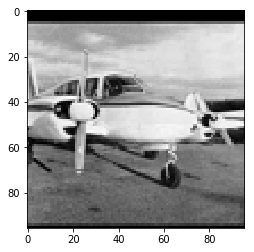

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 1 10  3  9  2]
Revised Top 5: [10  0  9  3  1]
..........................................................................................
Softmax Values:  [0.0000000e+00 3.7096390e-01 6.8179279e-04 3.2017446e-01 9.6803647e-05
 6.9118971e-05 9.9839694e-05 4.1784949e-04 1.4079211e-04 1.4353536e-02
 2.9300189e-01]
Openmax valuess:  [2.78985430e-01 1.51182151e-02 1.24443872e-02 3.50585028e-02
 4.52820090e-03 3.84763378e-04 3.16141338e-04 1.32955701e-03
 6.78784002e-04 3.64694882e-02 6.14686530e-01]


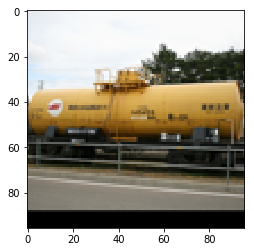

0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck
Prediction: Known
Unrevised Values:  [ 1  3 10  9  2]
Revised Top 5: [10  0  9  3  1]
..........................................................................................


In [30]:
#----------------------------META-RECOGNITION PART 2-------------------------------
for n in xrange(100,300):
    input_img = unlab_x[n].reshape((1,96,96,3))
    actvec = sess.run(logits,feed_dict = {feed_images:input_img,keep_prob:1.0})
    actvec = np.array(actvec[0])
    #print 'Activation Vector: ',actvec,'\n'
    #Calculating softmax values with unkown as 0.0
    softmax_val = np.exp(actvec)/np.sum(np.exp(actvec))
    softmax_val = np.insert(softmax_val,0,0.0)
    print 'Softmax Values: ',softmax_val
    #..........................Sorting the activation vector
    sorted_actvec = sorted(actvec)
    sorting_order = actvec.argsort()
    #print 'Sorted: ',sorted_actvec,'\n'
    #..................Calculatng alpha weight and dist from mean of each class
    alpha_weight = []
    dist_from_means = []
    for i in xrange(1,11):
        alpha_weight.append((11-i)/10.0)
        dist_from_means.append(np.sqrt(np.sum(np.square(np.subtract(actvec,mav[i-1])))))
    #print 'Distance from means:: ',dist_from_means,'\n'
    #..........................Calculating weilbull CDF score
    wscore = []
    #Unknown is taken as 0th label
    for i in xrange(1,11):
        wscore.append(1 - alpha_weight[i-1]*(1-models[i-1].w_score(dist_from_means[i-1])))
        
    #........................Calculating revised activation vector
    wscore = np.array(wscore)
    #print wscore
    revised_act = np.zeros((1,11))
    for i in xrange(1,11):
        revised_act[:,i] = actvec[i-1]*wscore[i-1]
    
    #Calculating activation vector value for 0th label i.e. unknown label
    revised_act[:,0] = np.sum(np.multiply(actvec,1 - wscore))
    #print revised_act
    #.........................Compute Openmax probabilities
    openmax_val = np.exp(revised_act)/np.sum(np.exp(revised_act))
    print 'Openmax valuess: ',openmax_val[0]
    #........................Checking the predictions
    top1_pred = np.argmax(np.array(openmax_val[0]))
    
    top5_preds = np.array(openmax_val[0]).argsort()[-5:][::-1]
    
    plt.imshow((unlab_x[n]+np.reshape(np.array([rmean,gmean,bmean]),(1,1,3)))/255)
    plt.show()
    print '0->Unknown|1->Aeroplane|2->Bird|3->Car|4->Cat|5->Deer|6->Dog|7->Horse|8->Monkey|9->Ship|10->Truck'
    if top1_pred == 0 or openmax_val[0][top1_pred] < 0.5:
        print 'Prediction: Unknown\n'
        print 'Unrevised Values: ',np.array(softmax_val).argsort()[-5:][::-1]
        print 'Revised Top 5:' ,top5_preds
    else:
        print 'Prediction: Known'
        print 'Unrevised Values: ',np.array(softmax_val).argsort()[-5:][::-1]
        print 'Revised Top 5:' ,top5_preds
    print '..........................................................................................'